# Introduction to statistics for hypothesis testing
This Jupyter notebook is intended to help explain statistical methods for hypothesis testing using code and examples (with minimal mathematics). It is restricted to univariate tests on continuous data, and focuses on issues that arise in neuroimaging, e.g, when there are multiple tests on topographically organised and smooth data. The code is written to aid comprehension, rather than for speed/efficiency. Some sections require having run code in preceding sections. It assumes basic knowledge of programming (eg. loops / functions / vectorisation). It was originally written for the MRC CBU's COGNESTIC Summer School, but can stand-alone.
It starts with sampling theory, central limit thoerem and randomisation testing, then proceeds to null hypothesis testing (error rate and power), focusing on T-tests and including Bayes Factors, then moves to the multiple comparison problem, height and cluster-level family-wise and false-disovery correction, before introducing the General Linear Model, ANOVAs, F-tests, error nonsphericity, error partitioning, multiple regression, timeseries, and finishes with Linear Mixed Effects models.

Needs python 3.11+, numpy, matplotlib, scipy, pandas, pymer (and notebook and ipykernel of course)

Any corrections/comments welcomed. Rik Henson, May 2024. rik.henson@mrc-cbu.cam.ac.uk. Thanks to Danny Mitchell for comments.

## Random Sampling
Let's assume we have data from a large population of people, where the values 
have a Gaussian distribution with mean of 0 and standard deviation (std) of 
1 (a "unit normal" distribution). We will create this distribution explicitly 
below for the sake of comprehension (even though most programming languages 
allow you to draw randomly from such a distribution on the fly):

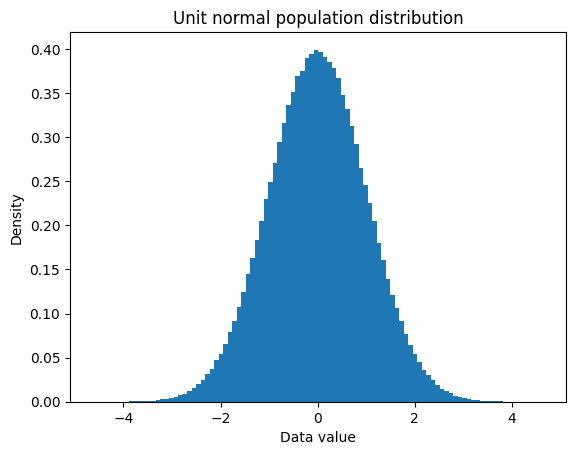

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1) # Initialise random seed
pop_size = int(1e6) # Needs to be big (but not exceed RAM!)
pop_mean = 0 
pop_std = 1
pop = np.random.randn(pop_size,1)*pop_std + pop_mean # Draw randomly from distribution
# Since pop_size finite, re-centre (important if pop_size not big enough)
pop = (pop - np.mean(pop))/np.std(pop) # Reset to exactly unit normal ("Z-scoring")
pop = pop*pop_std + pop_mean # Re-set to desired std and mean
pdf, bin_edges = np.histogram(pop, bins=100, density=True) # Plot histogram
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.title('Unit normal population distribution'); plt.xlabel('Data value'); plt.ylabel('Density'); plt.show()

Let's pretend we don't know the mean of the population, but want to estimtate it by drawing a random sample from the population. 

In [2]:
samp_size = int(1e2) # Sample size
select = np.random.randint(0, len(pop)-1, size=(samp_size, 1)) # random subset of people from population
samp = pop[select.squeeze()] # their values
print(f'Mean of one sample = {np.mean(samp):.3f}')

Mean of one sample = -0.003


We can make this process a function (technically, this is sampling with replacement, but when samp_size << pop_size, repeat values are extremely unlikely, and this is faster than sampling without replacement):

In [3]:
def sample_pop(pop, samp_size, num_samp):
    indices = np.random.randint(0, len(pop), size=(samp_size, num_samp))
    return np.squeeze(pop[indices], axis = -1)

But of course there will be uncertainty associated with any such estimate of the population mean from a smaller sample. We can see this by repeating the process many times, to get a new distribution, but this time of sample _means_:

Std of distribution of means of samples = 0.100


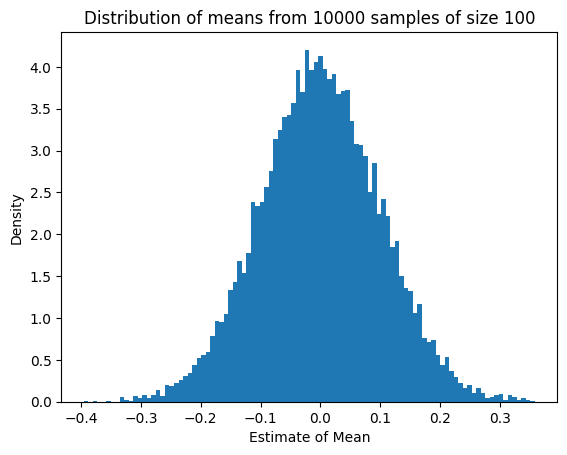

In [4]:
num_samp = int(1e4) # Number of samples
samp = sample_pop(pop, samp_size, num_samp)
mean_vals = np.mean(samp, axis=0)
pdf, bin_edges = np.histogram(mean_vals, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.title(f'Distribution of means from {num_samp:d} samples of size {samp_size:d}')
plt.xlabel('Estimate of Mean'); plt.ylabel('Density')
print(f'Std of distribution of means of samples = {np.std(mean_vals):.3f}')

Note that the std of the distribution of mean estimates ("standard error of mean") is equal to the std of the population divided by the square-root of the sample size - something we will come back to later. 

### Central Limit Theorem
Another thing worth noting about this distribution of mean estimates is that, with big enough sample size, it will approach a Gaussian distribution, even if the original population distribution is not Gaussian ("Central Limit Theorem"). So the population might be highly skewed or kurtotic:

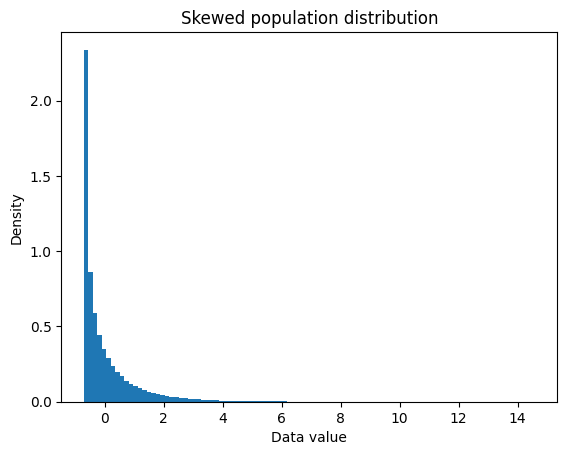

In [5]:
pop2 = pop**2 # Create a positively skewed distribution
pop2 = (pop2 - np.mean(pop2, axis=0)) / np.std(pop2) # Reset to have mean of 0 and std of 1 (if were Gaussian!)

pop3 = pop**3 # Create a positively kurtotic distribution
pop3 = (pop3 - np.mean(pop3, axis=0)) / np.std(pop3) # Reset to have mean of 0 and std of 1 (if were Gaussian!)

pdf, bin_edges = np.histogram(pop2, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.title('Skewed population distribution'); plt.xlabel('Data value'); plt.ylabel('Density');

#pdf, bin_edges = np.histogram(pop3, bins=100, density=True)
#plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
#plt.title('Kurtotic population distribution'); plt.xlabel('Data value'); plt.ylabel('Density');

But look what happens to distribution of means as sample size increases:

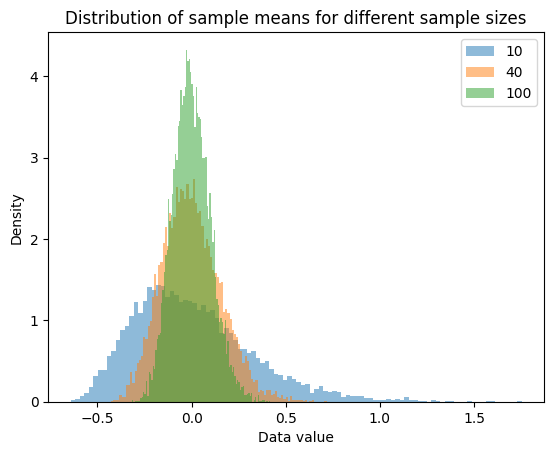

In [6]:
samp_size = [10, 40, 100] # Explore range of sample sizes
plt.figure()
for s, size in enumerate(samp_size):
    samp = sample_pop(pop2, samp_size[s], num_samp)
    mean_vals = np.mean(samp, axis=0)
    pdf, bin_edges = np.histogram(mean_vals, bins=100, density=True)
    plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0], alpha = 0.5)
plt.title('Distribution of sample means for different sample sizes')
plt.legend([f'{size}' for size in samp_size]); plt.xlabel('Data value'); plt.ylabel('Density');

Not only does the spread of the distributions decrease as sample size increases, but the distributions become more Gaussian (e.g, the distribution from a sample size of 10 is still skewed, like the native population, but hardly skewed when sample size is 100).

## Randomisation (permutation) testing
Normally we only have one sample, and hence only one mean, so how do we know whether the population mean is, for example, greater than 0? One way to estimate the variability of our mean estimate is to re-sample randomly, but this time from our single sample (rather than the population). One approach is to select values randomly with replacement, which is called "bootstrapping". However, another way that is more appropriate for hypothesis testing is called "permutation testing" (sampling without replacement). For testing the mean of a single sample, permutation is equivalent to randomly switching the sign of each value in the sample (see later example of a paired T-test for justification). This is a type of "randomisation" test (also called a "non-parametric" test). If we repeat this a large number of times, we get an estimate of the distribution of the mean: 

Std of distribution of means from randomisation = 0.086


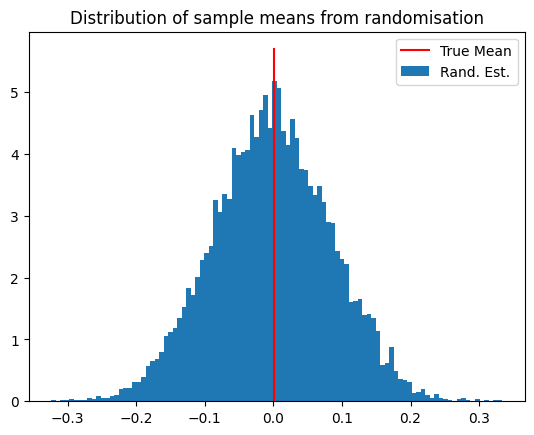

In [7]:
np.random.seed(1) # Initialise random seed
samp_size = int(1e2)
one_sample = sample_pop(pop, samp_size, 1)
num_rand = int(1e4) # Number of randomisations
mean_vals = np.empty(num_rand)
for r in range(num_rand):
    #resamp = one_sample[np.ceil(np.random.rand(samp_size, 1)*(samp_size-1)).astype(int)] # bootstrap sample with replacement (np.random.rand(x.shape[0], num_rand) * (x.shape[0] - 1)).astype(int)
    resamp = np.multiply(one_sample.T, np.sign(np.random.rand(samp_size) - 0.5)) # permutation sample with replacement
    mean_vals[r] = np.mean(resamp)
tmp = np.sign(np.random.rand(samp_size) - 0.5)
pdf, bin_edges = np.histogram(mean_vals, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
true_mean = np.mean(one_sample)
plt.plot([true_mean, true_mean], [0, 1.1*np.max(pdf)], 'r-')
plt.title('Distribution of sample means from randomisation'); plt.legend(['True Mean', 'Rand. Est.']);
print(f'Std of distribution of means from randomisation = {np.std(mean_vals):.3f}')

Notice that the standard error of the mean is again close to expected value of pop_std/sqrt(samp_size). This randomised distribution can be used to calculate confidence intervals around the mean, e.g, the upper part of the 95% confidence interval can be obtained by sorting the estimates of the mean from smallest to largest, and selecting the value just above the 95th percentile (assuming num_rand>100; see later):

In [8]:
mean_vals = sorted(mean_vals)
ci95 = mean_vals[int(np.floor(0.95 * len(mean_vals)))]
print(f'Sample mean is {true_mean:.3f} with upper 95-percent confidence interval of {ci95:.3f}')

Sample mean is 0.001 with upper 95-percent confidence interval of 0.141


In most cases (but does depend on your random seed!), the true mean should be less than the 95% upper confidence value. 

## Hypothesis Testing
We can now have a first stab at hypothesis testing. In traditional "null hypothesis 
signficance testing" (NHST), to test our hypothesis that the mean of the population 
is greater than 0 (sometimes called the alternate hypothesis, H1), we strive 
to reject the null hypothesis (H0) that the mean of the population is zero. 
To test this with our sample, we can use the randomise_one_sample function below, which just uses the permutation code above (or other randomisation 
method) and returns the proportion of permuted means that are as big, or bigger, 
than the actual sample mean:

In [9]:
def randomise_one_sample(y, num_rand=int(1e4), two_tailed=False, rand_method='permute', property='mean', critical_value=0):
    # Estimate probability that some property of a sample is greater (or smaller, if two-tailed)
    # than a critical value using a certain randomisation method.
    
    if property == 'mean':
        property_lambda = lambda y: np.mean(y, axis=0)
    elif property == 'tstat':
        property_lambda = lambda y: np.mean(y, axis=0) / (np.std(y, axis=0, ddof=1) / np.sqrt(y.shape[0])) 
    else:
        raise ValueError(f'Randomised property {property} unknown')
    
    num_samp = y.shape[1]
    
    if rand_method == 'permute':
        select = lambda x, num_rand: np.repeat(x, num_rand, axis=1) * np.sign(np.random.rand(x.shape[0], num_rand) - 0.5)
    elif rand_method == 'bootstrap':
        select = lambda x, num_rand: x[np.ceil(np.random.rand(x.shape[0], num_rand) * (x.shape[0] - 1)).astype(int)]
#        for s in range(num_samp):
#            y[:,s] = y[:,s] - property_lambda(y[:,s])  # Set property to 0 for null
    else:
        raise ValueError(f'Randomisation method {rand_method} unknown')
    
    y = y - critical_value  # Re-centre to critical value
    
    prop = np.full((num_samp), np.nan)
    for s in range(num_samp):
        ys = y[:, s]
        actual_value = property_lambda(ys)
        yr = select(ys[:,np.newaxis], num_rand)
        rand_dist = property_lambda(yr).T
        
        # Proportion of randomisations greater than actual value (equality and adding 1 to include actual sample itself)   
        if two_tailed:
            prop[s] = (np.sum(np.abs(rand_dist) >= np.abs(actual_value)) + 1) / (num_rand + 1)
        else:
            prop[s] = (np.sum(rand_dist >= actual_value) + 1) / (num_rand + 1)
    
    if num_samp == 1:
        prop = prop[0]
        
    return prop

So for example:

In [10]:
p_value = randomise_one_sample(one_sample, num_rand, two_tailed=False, rand_method='bootstrap', property='mean')
print(f'Proportion of randomised means greater than sample mean = {p_value:.3f}')

Proportion of randomised means greater than sample mean = 0.466


Under H0, this proportion is equally likely to lie anywhere between 0 and 1. This proportion is an estimate of the "p-value":  the probablity of getting a statistic as large or larger than a critical value, given that H0 is true. We generally want this p-value to be small, i.e. want minimal risk of falsely rejecting H0 when it is in fact true. This threshold is called "alpha" and is conventionally set at .05, ie 1 in 20 chance that we conclude the population mean is not zero when it is in fact. This is also called the false positive rate (or "type I error" rate).  

_Interesting factoid: What is the origin of 0.05 for alpha? A story says that the statistician Sir Ronald Fisher was crossing a court of his Cambridge college when someone yelled: "What odds would you trust for something not happening by chance?". Apparently he replied "1 in 20", perhaps without intending that this should become scientific dogma (though 0.05 was also used in his publications)._

### False positive rate and power
To check that our test does control false positive rate (FPR), we can simulate drawing many samples from the population (eg. doing many experiments), and calculate the proportion of experiments that give a false positive. We're going to assume a small sample though:

In [11]:
np.random.seed(1) # Initialise random seed
alpha = 0.05
samp_size = int(1e1) # a small sample size of 10
num_rand = int(1e4)  # to accurately estimate p-value
num_samp = int(1e4)  # to accurately estimate false positive rate (FPR)

pop_H0 = pop   # Gaussian
#pop_H0 = pop3 # Non-Gaussian (kurtotic)
p_values = np.full((num_samp,), np.nan)
for s in range(num_samp):
    samp = sample_pop(pop_H0, samp_size, 1)  # Take sample from Skewed population
    p_values[s] = randomise_one_sample(samp, num_rand, two_tailed=False, rand_method='permute', property='mean')
#    p_values[s] = randomise_one_sample(samp, num_rand, two_tailed=False, rand_method='bootstrap', property='mean')
#    p_values[s] = randomise_one_sample(samp, num_rand, two_tailed=False, rand_method='permute', property='tstat')
fpr = np.sum(p_values < alpha) / num_samp
print(f'Randomised (false) positive rate when population has zero-mean = {fpr:.3f}')

Randomised (false) positive rate when population has zero-mean = 0.051


This shows that our permutation test does ensure that only around 5% of experiments would produce a false positive. 

Note that the resolution of the estimated p-value depends on the number of random resamples. For example, if num_rand=1e2, then we could only estimate the p-value to 2 decimal places. In general, a minimum num_rand of 1e4 is recommended. However, p-value resolution can also be affected by the sample size if the samp_size is small. For example, if samp_size=10, there are 2^samp_size=1024 possible permutations for a one-sample test. Furthermore, the randomise_one_sample function does not enumerate all such permutations - it randomly samples possible permutations - making it likely that the same permutation will be sampled more than once if the sample size is not large enough (proper statistical software does enumerate all (or a subset of num_rand) permutations if feasible, but not done here to save time). So be wary of randomised p-values if the sample size is less than log2(1e4) (though note that greater resolution can be achieved by parametric approximation to the randomised distribution, e.g, using "percentile" interpolation).

But what if our hypothesis is true, and the population mean is greater than 0? How often does our test detect this? This is called the "power" of a test (sometimes denoted as 1-beta, given a certain alpha). Let's create a new population with mean of 0.5 (which corresponds to a Cohen's d effect size of 0.5, since Cohen's d is mean divided by std, and here std=1):

In [12]:
np.random.seed(1) # Initialise random seed
effect_size = 0.5            # Effect size for H1
pop_H1 = pop + effect_size   # (Gaussian population if H1 true)
#pop_H1 = pop3 + effect_size # (non-Gaussian population if H1 true)
p_values = np.full((num_samp,), np.nan)
for s in range(num_samp):
    samp = sample_pop(pop_H1, samp_size, 1)  # Take sample from population
    p_values[s] = randomise_one_sample(samp, num_rand, two_tailed=False, rand_method='permute', property='mean')
tpr = np.sum(p_values < alpha) / num_samp
print(f'Randomised (true) positive rate with population effect size {effect_size:.2f} = {tpr:.3f}')

Randomised (true) positive rate with population effect size 0.50 = 0.427


This is a power around 43% (normally we aim for >80%). Power increases with sample_size, as you will see later. 

Note that there are other classes of non-parametric tests that have analytic solutions, e.g, those that ignore the magnitude of values and use only their ranks (or even just their signs). These rank-based statistics test the null hypothesis that the median (rather than mean) is zero, but are not considered here. 

The real power of randomisation testing is that you can randomise any property (summary statistic) - you could randomise the median rather than mean for example. Indeed, later we are going to randomise properties like the maximum T-statistic, and the cluster size. In fact, it is preferable to randomise what are called pivotal statistics, which are statistics whose distribution does not depend on any unknown parameters. We know from above that the distribution of the sample mean depends on the unknown population standard deviation, so the mean is not a pivotal statistic. The Z-statistic and T-statistic are pivotal statistics, since they are normalised by the population standard deviation, so their values are independent of these. Nonetheless, permuting the mean is fine for present purposes.

## The T-test
Next though, we introduce the T-test. This test uses a T-statistic (sometimes called "Student's T") which is defined for one sample as the mean divided by the standard error of the mean:

In [13]:
one_t = lambda y: np.mean(y, axis=0) / (np.std(y, axis=0, ddof=1) / np.sqrt(y.shape[0]))

Some maths can show that, under certain assumptions (that the population is Gaussian), the T-values under H0 follow a distribution called the T-distribution, which depends only on the degrees of freedom (df). For this simple case of a one-sample test, the df = samp_size - 1 (the -1 because we have used one df in our data to estimate the mean). From this, we can create a function that calculates the ("one-tailed"; see later) probability of obtaining a value of T or higher:

In [14]:
from scipy.stats import t as tstat

T2p_higher = lambda T, df: 1 - tstat.cdf(T, df)

where "tstat.cdf" is the cumultive density function for the T distribution. This gives a p-value for a given T and df, eg:

In [15]:
samp_size = int(1e2)
samp = sample_pop(pop_H1, samp_size, 1)  # Take sample from population
T = one_t(samp)       # use last sample from above
df = samp_size - 1    # degrees of freedom
p = T2p_higher(T, df) # p-value (use "p" because now parametric)
print(f'T({df}) = {T[0]:.2f}, p = {p[0]:.3f}')

T(99) = 4.20, p = 0.000


For this sample (drawn from population with mean of 0.5), we reject H0 (that population mean is 0) because p<.05.

This is called a "parametric" test, because it depends on a parametric (here Gaussian) assumption about the distribution of the property under test (here the mean). According to the CLT shown earlier, this assumption becomes more likely as the sample size increases (in fact, when df is very large, the T-distribution becomes Gaussian, and the p-value is equivalent to that for the Z-statistic, where Z = mean/std). For smaller samples, there are tests to determine whether the sample comes from a normal distribution, but ironically, the smaller the sample size (and hence bigger the risk that the assumption of a Gaussian distribution of the mean is violated), the less sensitive such "tests of normality" become. This is why permutation testing, eg of the T-statistic itself, can be a more robust way of estimating the p-value when samples are small (providing the assumption of exchangeability respected; see later).

*Interesting factoid: the "Student" in "Student's T-test" was the pseudonym of a statistician called Gosset, who worked for Guinness to quality control batches of beer, and used the pseudonym to avoid the ban of publishing research that might have commerical implications.*

We can also check that the T-test controls the FPR and gives similar Power (note how much quicker this is than randomisation testing!):

In [16]:
np.random.seed(1) # Initialise random seed
samp_size = int(1e1)
pop_H0 = pop
samp = sample_pop(pop_H0, samp_size, num_samp) 
p = T2p_higher(one_t(samp), samp_size-1)
fpr = np.sum(p < alpha) / num_samp
print(f'False positive rate for T-test when H0 true = {fpr:.3f}')

pop_H1 = pop + effect_size
samp = sample_pop(pop_H1, samp_size, num_samp)
p = T2p_higher(one_t(samp), samp_size-1)
tpr = np.sum(p<alpha)/num_samp
print(f'True positive rate for T-test under H1 with effect size of {effect_size:.2f} = {tpr:.3f} (cf. for randomisation test above)')

False positive rate for T-test when H0 true = 0.049
True positive rate for T-test under H1 with effect size of 0.50 = 0.431 (cf. for randomisation test above)


However, what happens when parametric assumptions not met? We can repeat, but now drawing a large number of small samples from a non-Gaussian population (eg the kurtotic "pop3"):

In [17]:
np.random.seed(1) # Initialise random seed
samp_size = int(1e1)
#samp_size = int(1e4)
pop_H0 = pop3
samp = sample_pop(pop_H0, samp_size, num_samp) 
p = T2p_higher(one_t(samp), samp_size-1)
fpr = np.sum(p < alpha) / num_samp
print(f'False positive rate for T-test when H0 true = {fpr:.3f}')

pop_H1 = pop3 + effect_size
samp = sample_pop(pop_H1, samp_size, num_samp) 
p = T2p_higher(one_t(samp), samp_size-1)
tpr = np.sum(p<alpha)/num_samp
print(f'True positive rate for T-test under H1 with effect size of {effect_size:.2f} = {tpr:.3f}')

False positive rate for T-test when H0 true = 0.027
True positive rate for T-test under H1 with effect size of 0.50 = 0.687


The first thing to note is that the FPR is now less than alpha, i.e., the T-test has become conservative (ie. it "fails-to-safe"). The TPR has also decreased. This means the test may be less sensitive, but at least has not increased FPR above an accepted rate. 

So if this one-sample T-test is still conservative, even with small samples, you might wonder why we bother with permutation tests, given they are computationally expensive? One reason is that there are situations where parametric p-values from the T-statistic become capricious (see case of unequal variance for two-sample T-tests later). Another reason is to recover the sensitivity when the data (error) distribution is not Gaussian. Finally, as noted above, randomisation is more general, in that we can calculate probabilities for properties other than the mean or the T-statistic (such as the maximum; see later), which may not have a parametric (analytic) solution.

**Exercise: Compare the FPR and TPR (power) for this non-Gaussian distribution (pop3) to those using a permutation test above - what do you notice? Then increase the sample to 10000 for the T-test - what happens to the FPR? (The TPR will of course increase, but that is not relevant)**

So far, we have been testing H1 that the mean is greater than 0. This is called a directional or "one-tailed" test. We can also perform a two-tailed test to ask whether the mean is simply different from 0, by using the absolute value of T:

In [18]:
T2p_2tails = lambda T, df: 2*(1 - tstat.cdf(abs(T), df))

We can now calculate power curves for a two-tailed, one-sample T-test:

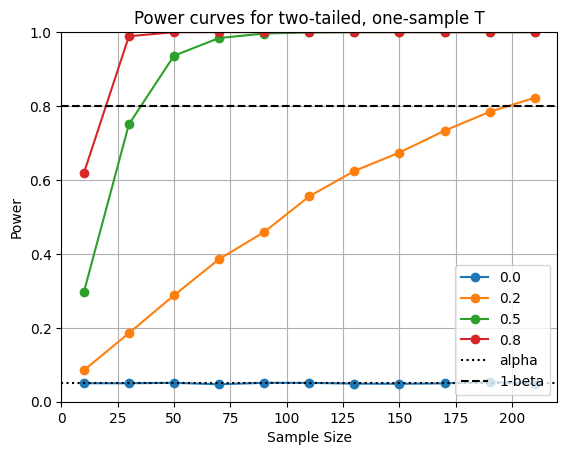

In [19]:
samp_sizes = np.arange(10, 220, 20)
effect_sizes = [0, 0.2, 0.5, 0.8]
fig, ax = plt.subplots()
ax.set_title('Power curves for two-tailed, one-sample T');
ax.set_xlabel('Sample Size'); ax.set_ylabel('Power');
ax.set_xlim(min(samp_sizes)-10, max(samp_sizes)+10);
ax.set_ylim(0, 1); ax.grid(True);

pr = np.full((len(samp_sizes), len(effect_sizes)), np.nan)
for es, effect_size in enumerate(effect_sizes):
    pop_H1 = pop + effect_size
    for s, samp_size in enumerate(samp_sizes):
        samp = sample_pop(pop_H1, samp_size, num_samp)
        p = T2p_2tails(one_t(samp), samp_size-1)
        pr[s, es] = np.sum(p < alpha) / num_samp

for es, effect_size in enumerate(effect_sizes):
    ax.plot(samp_sizes, pr[:, es], 'o-', label=f'{effect_size:.1f}')
ax.axhline(y=alpha, linestyle=':', color='k', label='alpha')
ax.axhline(y=0.8, linestyle='--', color='k', label='1-beta')
ax.legend(loc='lower right');


So for what Cohen called a "medium" effect size of 0.5, you now need a sample size of ~30 for 80% power, but for what he called a "small" effect of 0.2, you need around 200.

## Bayes Factors

The above classical or "frequentist" statistics estimate the likelihood of getting a statistic as large or larger than that obtained from the data, given that the null hypothesis is true. One consequence of this is that, if this p-value does not fall below our alpha, then we cannot reject H0, but nor can we accept it ("absence of evidence is not evidence of absence"). A Bayes Factor (BF) on the other hand is the ratio of two likelihoods: the probability of exceeding that statistic value if H1 is true, relative to the same probability if H0 is true (this ratio is often called BF10; while its reciprocal is BF01). A high BF10 (e.g, 6 or 10; a matter of convention like alpha) would constitute evidence for H1, whereas a high BF01 (low BF10) would constitute evidence for the null. Being able to claim support for H0 is a major strength of BFs (there are other philosophical differences that are beyond the present remit).

The problem with calculating a BF however is specifying H1 precisely. This means not just an effect size (which could be based on previous studies for example), but also the precise distribution of the effect. The nice thing about NHST is that scientists can generally agree that an effect of exactly 0 is a reasonable null, but with BFs, they also have to agree on H1. To estimate the likelihood under H1, one needs to impose some priors, and if scientists use different priors, they could come to different conclusions.

One solution called "subjective priors" is to use priors that come from previous data or simulations or theory. While other scientists might disagree with these, they can at least be specified in advance, ideally with agreement from independent reviewers (eg in a Study Registration). An alternative is to stick with "objective priors", i.e, default priors that do not differ by experiment, and which the community agrees in advance (e.g, default priors for a Bayesian T-test). (A third option is "empirical priors", which arise when we have heirarhical models, as mentioned later).

To calculate the likelihood of getting a statistic (here the mean), we need to parametrise its prior distribution under H0 and H1. The likelihood is then estimated by integrating over all possible values of these parameters (so-called "marginalisation").

For H0, this is easy, because the prior corresponds to a delta function at 0. So the likelihood is just the likelihood of getting the actual mean given the standard error of the mean. Under the assumption of a Gaussian distribution for the population, this likelihood is given by the normal probability density function (PDF):

In [20]:
from scipy.stats import norm

likelihood_mean = lambda y, mu: norm.pdf(np.mean(y), mu, np.std(y) / np.sqrt(len(y)))

Thus for a given sample:

In [21]:
samp_size = int(1e2)
samp = sample_pop(pop, samp_size, 1)
samp_mean = np.mean(samp)
likelihood_mean_H0 = likelihood_mean(samp, 0)
print(f'Likelihood of getting a mean of {samp_mean:.3f} from sample of {samp_size:d} when H0 true = {likelihood_mean_H0:.3f}')

Likelihood of getting a mean of -0.013 from sample of 100 when H0 true = 4.437


(note the likelihood is relative to integral of PDF, so not necessarily between 0-1). If we also assume a Gaussian distribution for H1, then this is fully described by two parameters: its mean and std. Here we assume the H1 mean is 0 (like H0), but by allowing a non-zero std (unlike H0), we increase the chance of mean values further from zero. If we can agree on a std (eg 0.5), then the likelihood under H1 is given by integrating over all possible values of the mean generated by this prior distribution:

In [22]:
from scipy.integrate import quad # For numerical integration

H1_mean = 0; H1_std = 0.5
prior_H1 = lambda x: norm.pdf(x, H1_mean, H1_std)
marginal_H1 = lambda x, y: likelihood_mean(y, x) * prior_H1(x)
likelihood_mean_H1, _ = quad(lambda x: marginal_H1(x, samp), -np.inf, np.inf)
print(f'Likelihood of getting a mean of {samp_mean:.3f} from sample of {samp_size:d} when H1 true = {likelihood_mean_H1:.3f}')

Likelihood of getting a mean of -0.013 from sample of 100 when H1 true = 0.785


BF10 is then just the ratio of these likelihoods:

In [23]:
BF10 = likelihood_mean_H1/likelihood_mean_H0
print(f'Bayes Factor for H1 relative to H0, BF10 = {BF10:.3f}')
print(f'(Bayes Factor for H0 relative to H1, BF01 = {1/BF10:.3f})')

Bayes Factor for H1 relative to H0, BF10 = 0.177
(Bayes Factor for H0 relative to H1, BF01 = 5.650)


BF10 will tend to be <1, since the data were sampled from a zero-mean population, so the BF should favour H0. Note there are other types of BF, for example based on the T-statistic rather than mean, and which use more sophisticated assumptions about the distributions of the mean and std, which are beyond present scope (such as the JZS prior common as the "objective prior" for a T-test). 

The above process is implemented in the function "one_sample_BF": 

In [24]:
def one_sample_BF(y, H1_std, H1_mean = 0):
    likelihood_mean = lambda y, mu: norm.pdf(np.mean(y), mu, np.std(y) / np.sqrt(len(y)))
    likelihood_mean_H0 = likelihood_mean(y, 0)
    
    prior_H1 = lambda x: norm.pdf(x, H1_mean, H1_std)
    marginal_H1 = lambda x, y: likelihood_mean(y, x) * prior_H1(x)
    likelihood_mean_H1, _ = quad(lambda x: marginal_H1(x, y), -np.inf, np.inf)
    return likelihood_mean_H1/likelihood_mean_H0

We can plot BFs as a function of the effect size in the data and the variability in the mean allowed by H1 (note this may take a minute or so to run):

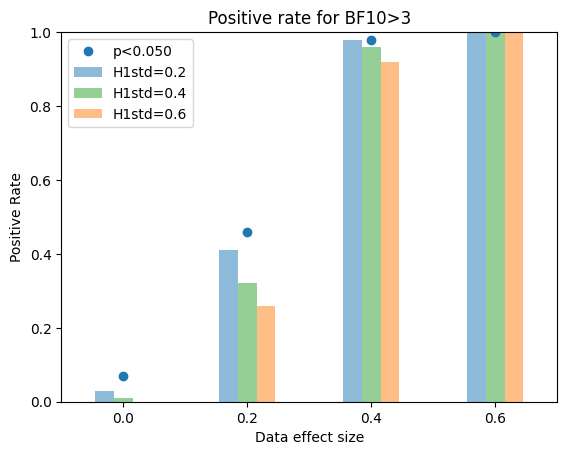

In [25]:
effect_sizes =  np.array([0, 0.2, 0.4, 0.6])  # effect sizes in data
H1_mean = [0, 0, 0]
H1_std = [0.2, 0.4, 0.6]  # variability under H1
num_samp = int(1e2) # reduce computation time
BF10_thr = 3

pr = np.full((len(effect_sizes), len(H1_std) + 1), np.nan)  # positive rate for BF10>thr
nr = pr.copy()  # negative rate for BF01>thr (BF10<1/thr)
for es, effect_size in enumerate(effect_sizes):
    pop_H1 = pop + effect_size
    samp = sample_pop(pop_H1, samp_size, num_samp)
    p = T2p_2tails(one_t(samp), samp_size-1)
    BF10 = np.full((num_samp, len(H1_std)), np.nan)
    for h1 in range(len(H1_std)):
        for s in range(num_samp):
            BF10[s, h1] = one_sample_BF(samp[:, s], H1_std[h1], H1_mean[h1])
    pr[es, 0]  = np.sum(p < alpha) / num_samp
    pr[es, 1:] = np.sum(BF10 > BF10_thr, axis=0) / num_samp
    nr[es, 1:] = np.sum(BF10 < 1 / BF10_thr, axis=0) / num_samp

txt = [f'p<{alpha:.3f}']
width =  np.array([0.03, 0.03, 0.03, 0.03])
bar_colours = ['tab:blue', 'tab:green', 'tab:orange']
plt.figure(); plt.plot(effect_sizes, pr[:, 0], 'o')
for h1 in range(len(H1_std)):
    txt.append(f'H1std={H1_std[h1]:.1f}')
    plt.bar(effect_sizes + (h1-1)*width, pr[:, h1+1], width, color = bar_colours[h1], alpha=0.5)
plt.title(f'Positive rate for BF10>{BF10_thr}')
plt.axis([-0.1, 0.7, 0, 1]); plt.legend(txt, loc='upper left'); plt.xticks(effect_sizes)
plt.xlabel('Data effect size'); plt.ylabel('Positive Rate');

The bars are for BFs with different priors for H1std, while the dots are for frequentist tests of H0. Note that thresholding BFs in the above manner leads to the NHST notion of (false) positive rates, and many Bayesians prefer to keep only the BF as a continuous estimate of how much one should update their beliefs given the data (or prefer to focus on the posterior distributions of the parameters themselves, which is beyond present remit). Nonetheless, the bars for effect size = 0 show comparable false positives when there is no effect. Importantly, when the effect size is greater than 0.2, the power for the BF approach increases as the prior std becomes tighter. Even more important however is the positive rate when the BF favours H0:

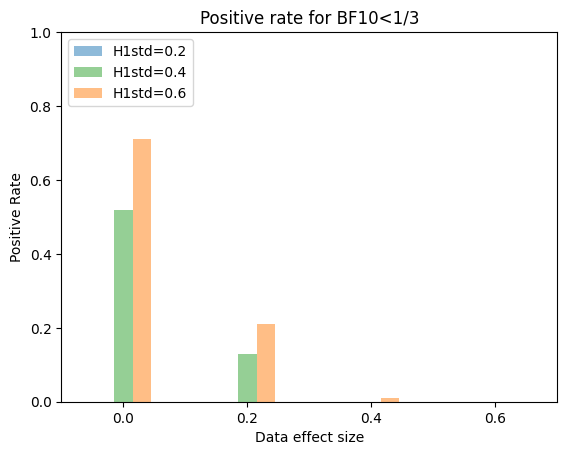

In [26]:
plt.figure()
txt = []
for h1 in range(len(H1_std)):
    txt.append(f'H1std={H1_std[h1]:.1f}')
    plt.bar(effect_sizes + (h1-1)*width, nr[:, h1+1], width, color = bar_colours[h1], alpha=0.5)
plt.title(f'Positive rate for BF10<1/{BF10_thr}')
plt.axis([-0.1, 0.7, 0, 1])
plt.legend(txt, loc='upper left'); plt.xticks(effect_sizes)
plt.xlabel('Data effect size'); plt.ylabel('Positive Rate');

This is not something we can calculate with a p-value (though classical "equivalence tests" perform a similar function), but with BFs, we have a reasonable chance of concluding that the evidence favours the null when the null is true (effect size is 0). Note that there is also some chance that we will support H0 when the true effect size is non-zero, but smaller than we expected (i.e, when effect size is 0.2 but H1std>0.2). This is not necessarily unreasonable. In other words, BFs are sensitive to the size of the effect; not just whether it is present (non-zero) or absent (zero).

**Exercise: what happens if you set prior mean of H1 to be >0, eg H1_mean = 0.6? You should see more cases when H0 is favoured when effect size is less than 0.6 (particularly when H1 std is small, ie when we have more precise expectations that effect should be 0.6) - understand?**

Another advantage of using BFs is they naturally allow sequential designs, where we keep collecting more data until our BF threshold (for H1 or H0) is exceeded, which can be more efficient on average (at risk of slight increase in false positives). Nonethless, we return to the currently more conventional frequentist p-values for the rest of this script (where there is at least less room for debate about priors).

## Multiple Comparisons (correcting for many tests)
Sometimes we have multiple hypotheses that we wish to test. This is common in neuroimaging, eg for an ERP from a single channel, where we might have a 100 time points, or a 3D MRI image of 100x100x100 voxels. We'll only consider the 1D case here, with the number of tests given by "num_tests", though the logic here generalises to more than one dimension. So our data will now be a 3D matrix of sample_size (eg, number of participants) by num_tests (eg, number of voxels) by num_samp (number of experiments), which we're going to call "y".

Let's start by assuming that each test is independent, and H0 is true for all tests. We now wish to control the "family-wise error rate" (FWE) of at least one false positive across all the tests (to be less than alpha):

Family-wise error rate = 0.927


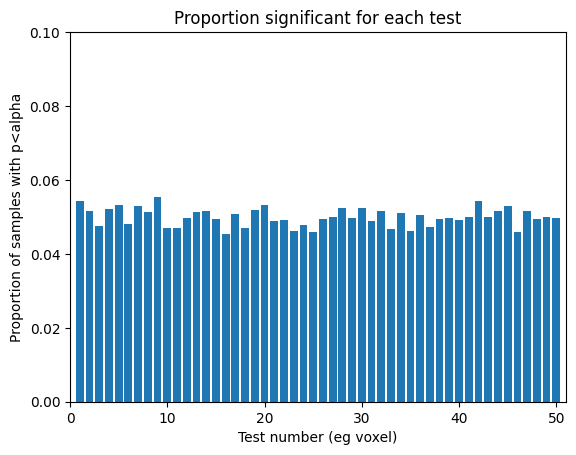

In [27]:
samp_size = 20
num_tests = 50
num_samp = int(1e4)

y = np.full((samp_size, num_tests, num_samp), np.nan)
p = np.full((num_tests, num_samp), np.nan)
for s in range(num_samp):
    samp = sample_pop(pop, samp_size, num_tests)
    y[:, :, s] = samp  # store for below
    p[:, s] = T2p_higher(one_t(samp), samp_size - 1)

sig = (p < alpha)
fig, ax = plt.subplots(); ax.bar(range(1, num_tests + 1), np.sum(sig, axis=1) / num_samp)
ax.set_title('Proportion significant for each test')
ax.set_xlim(0, num_tests + 1); ax.set_ylim(0, 0.1); 
ax.set_xlabel('Test number (eg voxel)'); ax.set_ylabel('Proportion of samples with p<alpha')
print(f'Family-wise error rate = {np.sum(np.any(sig, axis=0)) / num_samp:.3f}')

Although the FPR in each test is around 0.05, the FWE is much higher (i.e, likely that at least one test significant every time). One solution is to scale our threshold by the number of tests - the so-called "Bonferonni" correction:

Family-wise error rate = 0.054


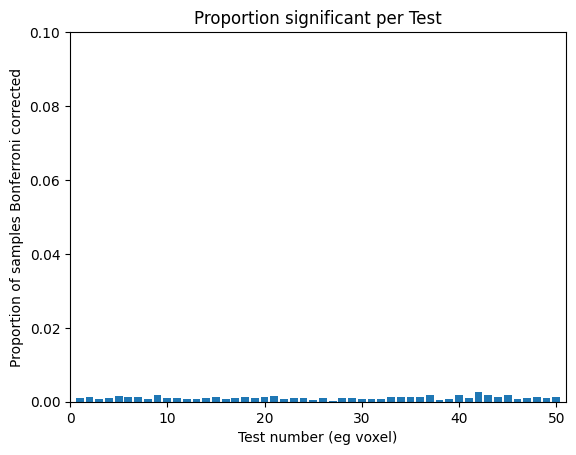

In [28]:
alpha_cor = alpha / num_tests  # Bonferroni correction
sig = (p < alpha_cor)
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=1) / num_samp)
plt.title('Proportion significant per Test'); plt.axis([0, num_tests+1, 0, 0.1]);
plt.xlabel('Test number (eg voxel)'); plt.ylabel('Proportion of samples Bonferroni corrected')
print(f'Family-wise error rate = {np.sum(np.any(sig, axis=0)) / num_samp:.3f}')

_Interesting factoid: Carlo Bonferonni was a keen climber of glaciers, but we don't know whether he corrected his chance of death by the number of his climbs._

This does control FWE at 5%. But in imaging, our tests are rarely independent. For example, ERP data are temporally autocorrelated across time, while MRI voxels are typically correlated across space. We can simulate this by smoothing our data (here with a simple, moving average of all values within a smooth_window for speed purposes):

In [29]:
smooth_window = 20
smooth_window = np.ones(smooth_window)/smooth_window
smooth_y = np.empty_like(y)
for s in range(num_samp):
    for p in range(samp_size):
        smooth_y[p,:,s] = np.convolve(np.squeeze(y[p,:,s]), smooth_window, mode='same')

In this case, Bonferronni correction is too conservative:

In [30]:
T = one_t(smooth_y)
p = T2p_higher(T, samp_size-1)
sig = (p < alpha_cor)
#plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=1)/num_samp)
#plt.title('Proportion significant for each test'); plt.axis([0, num_tests+1, 0, 0.1])
#plt.xlabel('Test number (eg voxel)'); plt.ylabel('Proportion of samples Bonferonni corrected');
print(f'Family-wise error rate = {np.sum(np.any(sig, axis=0))/num_samp:.3f}')

Family-wise error rate = 0.017


### Permuting maximal statistics
Fortunately, permutation tests come in useful here. It turns out that if we calculate the maximum T-value across tests, and its null distribution from permuting the data many times, then the (1-alpha) percentile of this distribution of "maxT"s provides a threshold that controls FWE at alpha, as demonstrated below:

Maximum T threshold = 3.048


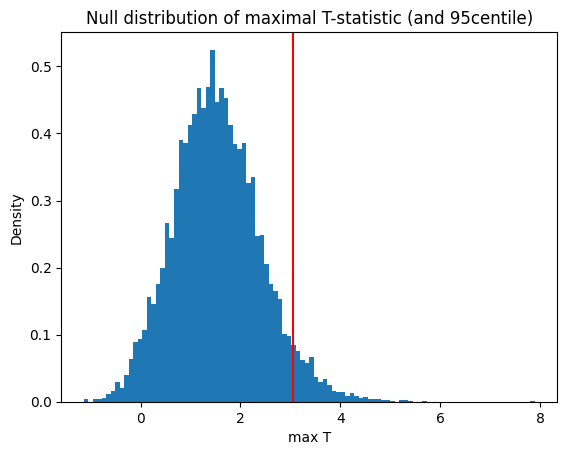

In [31]:
y1 = np.squeeze(smooth_y[:,:,0])  # Calculate max T thr from one sample (experiment) for speed
num_rand = int(1e4)
maxT_null = np.full(num_rand, np.nan)
for r in range(num_rand):
    rs = np.sign(np.random.rand(samp_size) - 0.5)
    ry = y1 * np.tile(rs, (num_tests,1)).T  # must use same randomisation for all participants
    rT = one_t(ry)
    maxT_null[r] = np.max(rT)
maxT_null = np.sort(maxT_null)
maxT_thr = maxT_null[int(np.floor((1-alpha)*num_rand))]
pdf, bin_edges = np.histogram(maxT_null, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.title(f'Null distribution of maximal T-statistic (and 95centile)')
plt.xlabel('max T'); plt.ylabel('Density')
plt.axvline(x=maxT_thr, color='r', label='threshold')
print(f'Maximum T threshold = {maxT_thr:.3f}')

(This is the basis of the "permute_maxT_one_sample" function below; note that it is important that each permutation is used for all voxels). 

In [32]:
def permute_maxT_one_sample(y, alpha=0.05, num_rand=10000):
    # Return vector of maxT thresholds for samp_size x num_tests matrix y
    samp_size = y.shape[0]
    num_tests = y.shape[1]
    r = np.sign(np.random.rand(samp_size, 1, num_rand) - 0.5)
    r = np.multiply(np.tile(y[:,:,np.newaxis],(1,1,num_rand)), np.tile(r, (1,num_tests,1)))   # must use same randomisation for all participants
    r = np.squeeze(np.mean(r, axis=0) / (np.std(r, axis=0) / np.sqrt(samp_size)))
    r = np.max(r, axis=0)
    if num_rand < 10000:
        maxT_thr = np.percentile(r, 100 * (1 - alpha))  # if insufficient permutations
    else:
        r = np.sort(r)
        maxT_thr = r[int(np.floor((1 - alpha) * num_rand))]
    return maxT_thr


Given this threshold for T-values, we can confirm the FWE is around .05: 

In [33]:
sig = (T > maxT_thr)
#plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=1) / num_samp)
#plt.title('Proportion significant for each test'); plt.axis([0, num_tests+1, 0, 0.1])
#plt.xlabel('Test number (eg voxel)'); plt.ylabel('Proportion of samples with p<alpha')
print(f'Family-wise error rate = {np.sum(np.any(sig, axis=0)) / num_samp:.3f}')

Family-wise error rate = 0.047


Note that one should calculate maxT_thr for each new sample (experiment), but since our simulated experiments are identical, it is quicker to approximate this threshold for one dataset and apply to all experiments (cf. cluster size below).

We can now repeat for the unsmoothed case, confirming we still maintain FWE:

In [34]:
y1 = np.squeeze(y[:,:,0]) # Take first experiment to calculate Tthr
maxT_thr = permute_maxT_one_sample(y1)
T = one_t(y)
sig = (T > maxT_thr)
#plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=1)/num_samp)
#plt.title('Proportion significant for each test'); plt.axis([0, num_tests+1, 0, 0.1])
#plt.xlabel('Test number (eg voxel)'); plt.ylabel('Proportion of samples with p<alpha')
print(f'Family-wise error rate = {np.sum(np.any(sig, axis=0))/num_samp:.3f}')

Family-wise error rate = 0.046


Now let's add some signal (to the original unsmoothed data). If consider the tests as voxels in a 1D image for the moment, let's assume a large but "localised" effect for voxel index 30, plus a smaller but "distributed" effect across 10 voxels 10 to 19 inclusive (9-18 in python!):

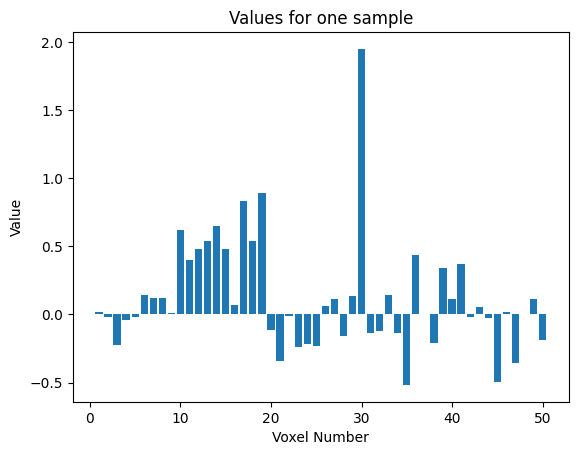

In [35]:
y_signal = y.copy()
y_signal[:, 29, :] = y[:, 29, :] + 2
y_signal[:, 9:19, :] = y[:, 9:19, :] + 0.5
y1 = np.squeeze(y_signal[:, :, 0])  # Select example sample (first will do)
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.mean(y1, axis=0));
plt.title('Values for one sample'); plt.xlabel('Voxel Number'); plt.ylabel('Value');

Let's see what the positive rates look like over lots of experiments:

Text(0, 0.5, 'Proportion of samples with p<alpha')

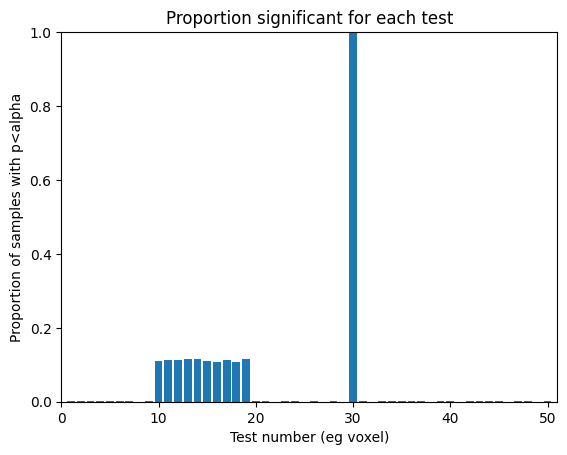

In [36]:
maxT_thr = permute_maxT_one_sample(y1)
T = one_t(y_signal)
sig = (T > maxT_thr)
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=1) / num_samp)
plt.title('Proportion significant for each test')
plt.axis([0, num_tests+1, 0, 1]) # Note increase in y-axis scale
plt.xlabel('Test number (eg voxel)'); plt.ylabel('Proportion of samples with p<alpha')
#print(f'Family-wise positive rate = {np.sum(np.any(sig, axis=0)) / num_samp:.3f}')

We can detect the localised activation most of the time, but not the diffuse activation. One solution to the latter is to smooth the data, chosing a smoothing window that matches the extent of the diffuse cluster:

In [37]:
smooth_window = 10
smooth_window = np.ones(smooth_window)/smooth_window
smooth_y_signal = np.empty_like(y_signal)
for s in range(num_samp):
    for p in range(samp_size):
        smooth_y_signal[p,:,s] = np.convolve(np.squeeze(y_signal[p,:,s]),smooth_window, mode='same')


Note that data may be intrinsically smooth, but we often want to explicitly smooth. One reason for this is to help justify the parametric assumptions of T-test, because smoothing effectively increases the amount of data being averaged, and so  benefits from the CLT.

So what happens when we apply the same maximum T threshold to the smoothed data:

Text(0, 0.5, 'Proportion of samples with p<alpha')

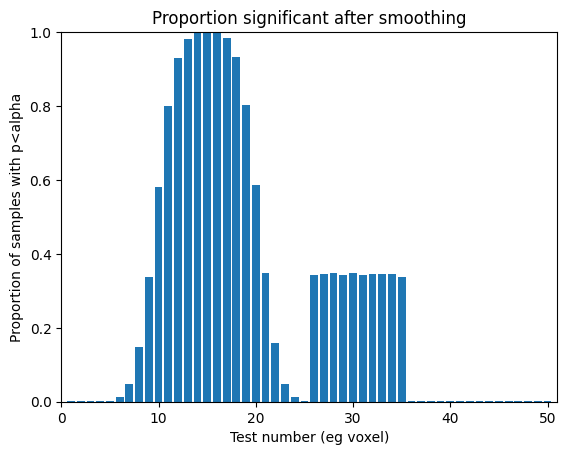

In [38]:
y1 = np.squeeze(smooth_y_signal[:, :, 0])  # Select example sample (first will do)
maxT_thr = permute_maxT_one_sample(y1)
T = one_t(smooth_y_signal)
sig = (T > maxT_thr)
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=1) / num_samp)
plt.title('Proportion significant after smoothing'); plt.axis([0, num_tests+1, 0, 1]) # Note increase in y-axis scale
plt.xlabel('Test number (eg voxel)'); plt.ylabel('Proportion of samples with p<alpha')
#print(f'Family-wise positive rate = {np.sum(np.any(sig, axis=0)) / num_samp:.3f}')

You will notice that, while the power to detect voxels in the diffuse cluster has increased, that for the localised voxel has decreased, and its signal has in fact been smoothed into nearby voxels.

**Exercise: compare results with a smaller (eg 5) or bigger (eg 20) smoothing window (kernel) - do the results support the "matched filter theorem"?**

### Cluster-level Correction
But can we avoid "blurring" the data by smoothing, and still detect diffuse signals? Here permutation testing again helps us, because rather than permuting the maximal T value (which is suitable for detecting whether a single voxel is significant, sometimes called "peak" or "height" thresholding), we could permute the "cluster extent" - ie the number of contiguous voxels above some initial threshold. 

We first need to determine the cluster size after an initial thresholding of voxels, and label each voxel with the size of the cluster in which it sits. This is done by the function "label_with_cluster_size":

In [39]:
def label_with_cluster_size(x,thr):
    # label elements of x with size of cluster containing them, given threshold thr
    st = (x > thr).astype(int)
    cs = np.zeros_like(st)
    dp = np.diff(np.concatenate(([0], st, [0]))).nonzero()[0] # Find the positions where changes occur in st
    sp = dp[0::2] # Start points of segments
    ep = dp[1::2] # End points of segments
    dp = ep - sp  # Length of segments
    for c in range(len(dp)): # Fill cs with the lengths of segments
        cs[sp[c]:ep[c]] = dp[c]
    return cs

Here is an example, using p<.05 to define clusters:

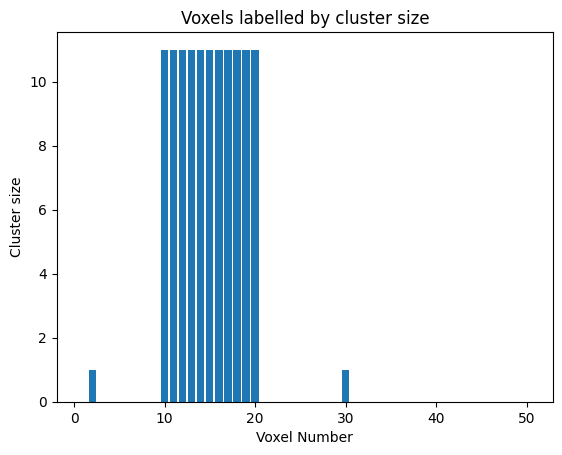

In [40]:
from scipy.special import stdtrit as Tinv
y1 = np.squeeze(np.mean(y_signal,axis=2)) # mean of many samples of unsmoothed
cluster_defining_Tval = Tinv(samp_size-1, 1-alpha) # initial threshold to define clusters
cs = label_with_cluster_size(one_t(y1), cluster_defining_Tval)
plt.figure(); plt.bar(np.arange(1, num_tests+1), cs)
plt.title('Voxels labelled by cluster size'); plt.xlabel('Voxel Number'); plt.ylabel('Cluster size');

Note that the diffuse cluster is labelled with true size of 10 (because we have averaged out most of noise by averaging across many experiments), while the local activation is labelled correctly with size of 1 (and there might be additional spurious clusters, depending on random seed). We can now estimate the distribution of maximal cluster size: 

In [41]:
y1 = np.squeeze(y_signal[:,:,0])  # Calculate cluster thr from one sample (experiment) for speed
cs_null = np.empty(num_rand,dtype=int)
cluster_defining_Tval = Tinv(samp_size-1, 1-alpha) 
for r in range(num_rand):
    rs = np.sign(np.random.rand(samp_size) - 0.5)
    ry = y1 * np.tile(rs, (num_tests,1)).transpose()  # must use same randomisation for all participants
    rT = one_t(ry)
    cs_null[r] = np.max(label_with_cluster_size(rT, cluster_defining_Tval))
cs_null = np.sort(cs_null)
cs_thr  = cs_null[int(np.floor((1-alpha)*num_rand))]
print(f'Minimum extent for cluster-level for FWE correction = {cs_thr}')

Minimum extent for cluster-level for FWE correction = 2


Thus clusters of at least 2 contiguous voxels are unlikely by chance. Note that the initial threshold (here the T-value corresponding to p<.05 uncorrected) will affect extent threshold. We can use this to do "cluster-level correction", as done in the "permute_cluster_metric_one_sample" function below (with "size" as the metric):

In [42]:
def permute_cluster_metric_one_sample(ys,thrs,alpha=0.05,num_rand=int(1e4),metric='size'):
    # Return vector of cluster size thresholds for samp_size x num_tests matrix y
    # given height threshold(s) (thrs)
    samp_size = ys.shape[0]
    num_tests = ys.shape[1]
 
    rs = np.sign(np.random.rand(samp_size, num_rand) - 0.5)
    
    null_dist = np.full(num_rand, np.nan)
    match metric:
        case 'size':
            for b in range(num_rand):
                r = ys * np.tile(rs[:,b],(num_tests, 1)).transpose()
                r = one_t(r)
                cs = label_with_cluster_size(r,thrs[0])
                null_dist[b] = np.max(cs)
        case 'TFCE': 
            for b in range(num_rand):
                r = ys * np.tile(rs[:,b],(num_tests, 1)).transpose()
                r = one_t(r)
                cm = label_with_cluster_TFCE(r,thrs)
                null_dist[b] = np.max(cm)
        case _:
            error('Unknown metric')

    if num_rand < 10000:
        cluster_thr = np.percentile(null_dist, 100 * (1 - alpha))  # if insufficient permutations
    else:
        null_dist = np.sort(null_dist)
        cluster_thr = null_dist[int(np.floor((1 - alpha) * num_rand))]
    
    return cluster_thr 

We can now see how this cluster threshold of 2 adjacent voxels affects power (though with only 50 voxels and hence small range of cluster sizes, we could also lower the cluster-defining threshold to get a larger range of cluster sizes):  

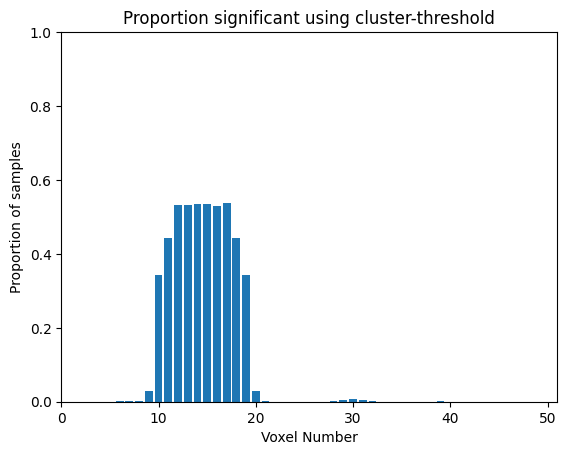

In [43]:
num_samp = int(1e4) # reduce if need to speed up
#cluster_defining_Tval = 0.5 # if want to reduce initial cluster-defining height threshold
cs = np.empty([num_samp,num_tests])
cs_thr = np.empty(num_samp)
for s in range(num_samp):
    ys = np.squeeze(y_signal[:,:,s])
    T = one_t(ys)
    if s==0: # Faster to estimate from one sample, since all samples asymptotically equivalent
        cs_thr[s] = permute_cluster_metric_one_sample(ys,np.array([cluster_defining_Tval]),alpha,num_rand,'size')
    else:
        cs_thr[s] = cs_thr[0]
    #    cs_thr[s] = permute_cluster_metric_one_sample(ys,np.array([cluster_defining_Tval]),alpha,num_rand,'size')
    cs[s,:] = label_with_cluster_size(T,cluster_defining_Tval)
    cs[s,:] = (cs[s,:] > cs_thr[s])
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(cs, axis=0) / num_samp)
plt.title('Proportion significant using cluster-threshold')
plt.axis([0, num_tests+1, 0, 1]) 
plt.xlabel('Voxel Number'); plt.ylabel('Proportion of samples');
pr = np.sum(np.any(cs, axis=1)) / num_samp
#print(f'Family-wise positive rate using cluster-threshold = {pr:.3f}')

Notice that the diffuse cluster is now detected reasonably well, but the localised one is not (cf. the case for corrected peak threshold earlier). We are basically trading-off statistical sensitivity for localising power: with the cluster-level correction, we are more sensitive (to clusters), but are unable to localise within clusters (ie cannot claim a particular voxel within a cluster is significant). The power is not as high as when smoothing the data previously (since smoothing reduces noise by pooling over nearby voxels), but at least we have fewer false positives (<5%) for voxels outside the true activation (compare voxels 9 and 20 with smoothed results above).

**Exercise: Here we have applied to the unsmoothed data with signal, but you can see what happens for the smoothed data, smooth_y_signal, or the unsmoothed data with no signal, y (to check FWE), or what happens as you change the initial cluster-defining height threshold (e.g, making lower as in commented code above). You can also compare results when the threshold is calculated for each sample separately (by uncommenting the line after "else" above), and examine the range of extent thresholds resulting (cs_thr), but it will take a long time...**

Note that there are parametric versions that correct FWE for peak or cluster extent using "Random Field Theory" but they are beyond the present scope. They also make more assumptions, such as requiring data to have a minimal smoothness, and a sufficiently stringent initial threshold for defining cluster size.

### Threshold-free cluster enhancement (TFCE)

Given above, how about permuting a property that includes a contribution from both the height and extent of each cluster, such as the cluster "mass" (e.g, the product of height and extent of each cluster in the current 1D example)? Note also that the results from the above cluster-level correction still depend on the initial height threshold that defines the clusters. "Threshold-free Cluster Enhancement" (TFCE) is a popular method that combines these two ideas, by integrating cluster masses across a range of thresholds. To use it, we  first need to define a function for calculating cluster mass, which takes a range of thresholds (and parameters H and E that can be further optimised):

In [44]:
def label_with_cluster_TFCE(x,thrs,H=1,E=1):    
    # label elements of x with cluster "mass", given range of thresholds thrs  
    # Note E=0.5, H=2 optimal from Nichols paper 
    TFCE = np.zeros_like(x)
    for thr in thrs:
        st = (x > thr).astype(int)
        dp = np.diff(np.concatenate(([0], st, [0]))).nonzero()[0] # Find the positions where changes occur in st
        sp = dp[0::2] # Start points of segments
        ep = dp[1::2] # End points of segments
        dp = ep - sp  # Length of segments
        for c in range(len(dp)): # Fill cm with the masses of segments
            cm = dp[c]**E * x[sp[c]:ep[c]]**H
            TFCE[sp[c]:ep[c]] = TFCE[sp[c]:ep[c]] + np.sum(cm)
    return TFCE

Now we can examine its sensitivity to both the diffuse and focal signal in our example... (Note that we use a set of 3 fixed cluster-defining thresholds, but you could define a set based on 3 (or more) percentiles of the range of T-values, which would adjust thresholds to the SNR in the data)

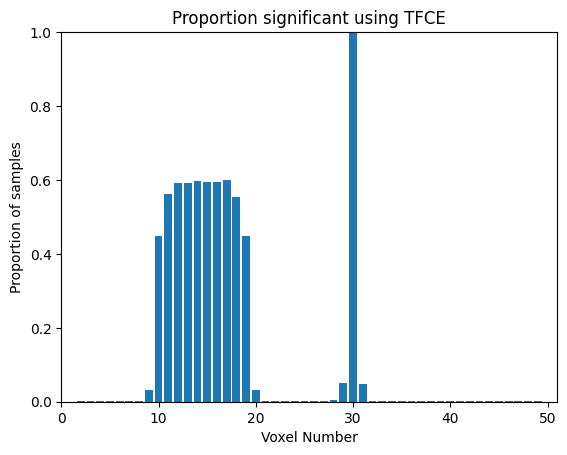

In [45]:
p_range = np.array([0.05, 0.01, 0.001]) # range of cluster-defining p-values (can add more, but will take more time)
T_range = Tinv(samp_size-1, 1-p_range)  # ...equivalent T-values

cm = np.empty([num_samp,num_tests])
cm_thr = np.empty(num_samp)
for s in range(num_samp):
    ys = np.squeeze(y_signal[:,:,s])
    T = one_t(ys)
    if s==0: # Faster to estimate from one sample, since all samples asymptotically equivalent
        cm_thr[s] = permute_cluster_metric_one_sample(ys,T_range,alpha,num_rand,'TFCE')
    else:
        cm_thr[s] = cm_thr[0]
    #    cm_thr[s] = permute_cluster_metric_one_sample(ys,T_range,alpha,num_rand,'TFCE')
    cm[s,:] = label_with_cluster_TFCE(T,T_range)
    cm[s,:] = (cm[s,:] > cm_thr[s])
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(cm, axis=0) / num_samp)
plt.title('Proportion significant using TFCE'); plt.axis([0, num_tests+1, 0, 1]); 
plt.xlabel('Voxel Number'); plt.ylabel('Proportion of samples');
pr = np.sum(np.any(cm, axis=1)) / num_samp
#print(f'Family-wise positive rate using TFCE = {pr:.3f}')

Now we are detecting both the diffuse activation and the localised activation with reasonable power, which is neat! 

**Exercise: You can also play with H and E to optimise to extent or height, or if you want a more advanced exercise, you could modify the code above to handle two-tailed tests, ie possible deactivations (hint: you need to permute clusters separately for each tail).**


## False Discovery Rate (FDR)

Another common correction for multiple comparisons is not to control the FWE, but rather something called the False Discovery Rate (FDR). In the "Benjamini-Hochberg" version of FDR, the p-values are sorted from smallest to largest, and checked against thresholds with decreasing levels of correction, and then all p-values up to the largest that survives this threshold are declared significant ("discoveries"). 

Number of discoveries using FDR = 4


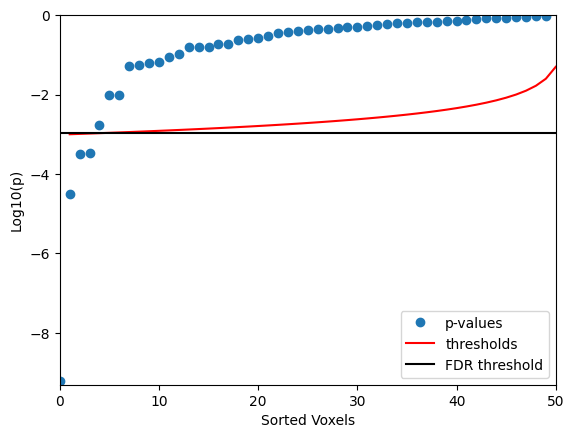

In [46]:
y1 = np.squeeze(y_signal[:,:,1])  
#y1 = np.squeeze(smooth_y_signal[:,:,0])  
#y1 = np.squeeze(smooth_y[:,:,0])     # No true positives
#y1 = np.squeeze(smooth_y[:,:,0])+10  # All true positives
T = one_t(y1)
p = T2p_higher(one_t(y1), samp_size-1)
thr = alpha / np.arange(num_tests, 0, -1)
ps = np.sort(p) + np.finfo(float).eps # eps added to avoid log(0) below
st = np.where(ps < thr)[0]
plt.figure(); plt.plot(np.log10(ps), 'o');
plt.ylabel('Log10(p)'); plt.xlabel('Sorted Voxels');
plt.plot(np.arange(1, num_tests+1), np.log10(thr), 'r-')
if st.size > 0:
    FDRthr = thr[st[-1]]
else:
    FDRthr = thr[0]
plt.axhline(y=np.log10(FDRthr), color='k');
plt.axis([0, num_tests, np.log10(np.min([ps, thr]))-0.1, 0]);
plt.legend(['p-values', 'thresholds', 'FDR threshold'], loc='lower right');
print(f'Number of discoveries using FDR = {len(st):d}')

Note that FDR defaults to Bonferroni if there are no true positives, and defaults to uncorrected alpha if they are all true positives.

FDR is compared with FWE in the example below, where signal is put in first 40 voxels but not the remaining 10: 

Mean error rate in non-active voxels under FWE = 0.015
Mean error rate in non-active voxels under FDR = 0.031


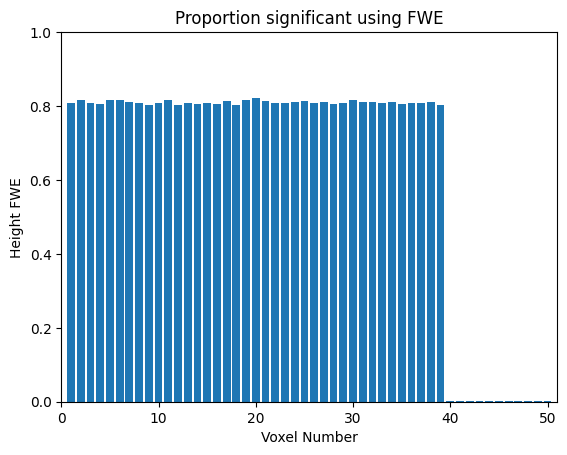

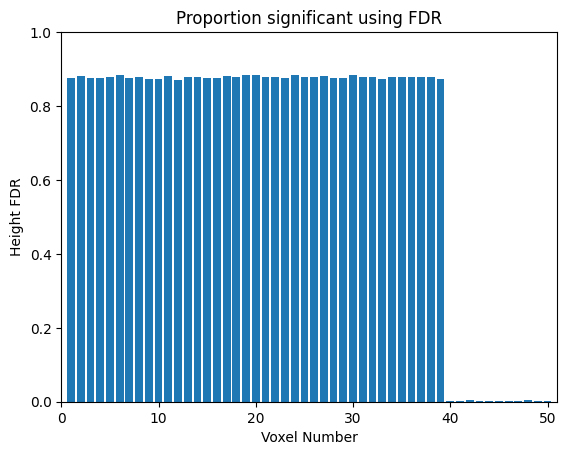

In [47]:
y_signal = y.copy()  
y_signal[:,0:39,:] = y[:,0:39,:] + 1 # Add signal to first 40 voxels

# FWE correction
y1 = np.squeeze(y_signal[:,:,0])  # Select example sample for max T threshold
maxT_thr = permute_maxT_one_sample(y1)
T = one_t(y_signal)
sig = (T > maxT_thr).T
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=0) / num_samp)
plt.title('Proportion significant using FWE'); plt.axis([0, num_tests+1, 0, 1]) 
plt.xlabel('Voxel Number'); plt.ylabel('Height FWE');
pr = np.sum(np.any(sig[:,40:], axis=1)) / num_samp
print(f'Mean error rate in non-active voxels under FWE = {pr:.3f}')

# FDR correction
p = T2p_higher(T, samp_size-1)
sig = np.zeros_like(p).T
for s in range(num_samp):
    ps  = np.sort(p[:, s], axis = 0)
    ind = np.argsort(p[:, s], axis = 0)
    st  = np.where(ps < thr)[0]
    if len(st) > 0: 
        max_st = np.max(st)
        sig[s,ind[0:max_st]] = 1
plt.figure(); plt.bar(np.arange(1, num_tests+1), np.sum(sig, axis=0) / num_samp)
plt.title('Proportion significant using FDR'); plt.axis([0, num_tests+1, 0, 1]); 
plt.xlabel('Voxel Number'); plt.ylabel('Height FDR');
pr = np.sum(np.any(sig[:,40:], axis=1)) / num_samp
print(f'Mean error rate in non-active voxels under FDR = {pr:.3f}')

Note FDR leads to more true positives for the first 40 voxels. However, this comes at the cost of increased false positives in non-active voxels (the remaining 10 voxels). This is because FDR controls the number of false positives as a proportion (eg 5%) of voxels declared significant, rather than as a proportion of tests performed (like FWE). So the more active voxels there are in one part of the image, the more false positives are likely in other parts of the image where there is no signal. Thus it is really a qualitatively different type of inference, and some would argue that maintaining the traditional FWE is more important. 

Finally, note that all the methods above are designed for (safe) inferences on "mass univariate" tests. This is appropriate if the aim is localisation in space or time, but if the aim is to detect signal anywhere, there are much more sensitive "multivariate" tests like PLS/CCA that leverage on covariance between tests.

## Two-sample T-tests

We now turn to two-sample tests. Here H0 is often that the means of (whatever generated) two samples are equal. We start with the easy case of a "paired" test, where two "conditions" are measured on the same people, i.e., each person contributes two values (sometimes called a "repeated measure"). In this case, we can simply calculate the difference between these two values for each person, and run a one-sample test on these "difference scores". In the context of a permutation test, we would be randomly swapping the two values for each person, hence the basis for randomising the sign of the (difference) values in the one-sample test examples above.

More interesting is the "unpaired" (or "independent samples") case, when the samples (groups) are drawn from two populations of different people, and we have one value per person. Under H0 that these populations are identical, we could randomly assign people to either group. This is called "exchangeability"; in the unpaired case, all values are exchangeable, whereas in the paired case, only values within the same person are exchangeable (exchangeability is normally a condition of randomisation tests). If there are N1 people in sample of first population, and N2 in second sample, then for a permutation test, there are (N1+N2)!/(N1!N2!) permutations, which quickly gets very large as N1 and/or N2 increase. Nonetheless, it is normally sufficient to sample ~1e4 to estimate a p-value, as done in the function "randomise_two_samples" below. 


In [48]:
def randomise_two_samples(y, num_rand=10000, two_tailed=False, rand_method='permute', property='mean'):
    # Estimate probability that some property of second independent sample is greater (or smaller, if two-tailed)
    # than that of a first sample, using a certain randomisation method.

    if property == 'mean':
        property_lambda = lambda y: np.mean(y[1],axis=0) - np.mean(y[0],axis=0)
    elif property == 'tstat':
        pool_var        = lambda y: ((y[0].shape[0]-1)*np.var(y[0], ddof=1) + (y[1].shape[0]-1)*np.var(y[1], ddof=1)) / (y[0].shape[0] + y[1].shape[0] - 2)
        property_lambda = lambda y: (np.mean(y[1],axis=0) - np.mean(y[0],axis=0)) / np.sqrt(pool_var(y) * (1/y[0].shape[0] + 1/y[1].shape[0]))
 #       property_lambda = lambda y: (np.mean(y[1],axis=0) - np.mean(y[0],axis=0)) / np.sqrt(np.var(y[0], ddof=1)/y[0].shape[0] + np.var(y[1], ddof=1)/y[1].shape[0])

    if rand_method == 'permute':
        select = lambda x, num_rand: x[np.random.rand(x.shape[0], num_rand).argsort(axis=0)] # faster than np.shuffle
    elif rand_method == 'bootstrap': 
        select = lambda x, num_rand: x[np.ceil(np.random.rand(x.shape[0], num_rand) * (x.shape[0] - 1)).astype(int)]
    else:
        raise ValueError(f'Randomisation method {rand_method} unknown')
    
    samp_size = np.array([2,1])
    samp_size[0] = y[0].shape[0]
    yc = np.concatenate(y, axis=0)
    num_samp = yc.shape[1]

    prop = np.full((num_samp), np.nan)
    for s in range(num_samp):
        actual_value = property_lambda([y[0][:,s], y[1][:,s]])
        ys = yc[:, s]
        yr = select(ys, num_rand)
        yp = [yr[:samp_size[0]], yr[samp_size[0]:]] # convert back into two samples
        rand_dist = property_lambda(yp)
        if two_tailed:
            prop[s] = (np.sum(np.abs(rand_dist) >= np.abs(actual_value)) + 1) / (num_rand + 1)
        else:
            prop[s] = (np.sum(rand_dist >= actual_value) + 1) / (num_rand + 1)

    if num_samp == 1:
        prop = prop[0]
        
    return prop

Alternatively, we can also use a parametric approach.  There are several versions of the parametric version of the two-sample T-test, but we can start with a standard one that assumes equal variance in both groups:

In [49]:
pool_var = lambda y: ((y[0].shape[0]-1)*np.var(y[0], ddof=1) + (y[1].shape[0]-1)*np.var(y[1], ddof=1)) / (y[0].shape[0] + y[1].shape[0] - 2)
two_t = lambda y: (np.mean(y[1],axis=0) - np.mean(y[0],axis=0)) / np.sqrt(pool_var(y) * (1/y[0].shape[0] + 1/y[1].shape[0]))

The first "pool_var" function above pools the variance across both groups, weighted by their respective sizes. This pooled estimate of variance is then used in the second function "two_t", in which the numerator is the difference of group means, while the denominator is equivalent to the pooled standard error. The p-value can then be calculated from the same T-distribution with dfs equal to the total number across both groups minus 2 (the 2 dfs used for estimating the mean within each group).

Assuming equal group sizes, we can plot power curves for two-tailed, unpaired T-tests as a function of group sizes:

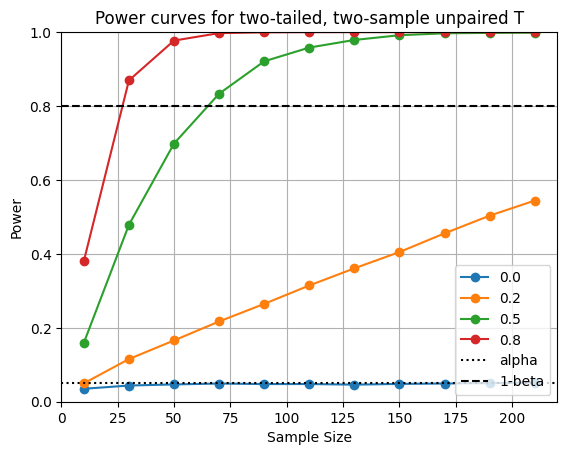

In [50]:
num_rand = int(1e4)
num_samp = int(1e4) # Reduce if uncomment randomisation below and want to save time
samp_sizes = np.arange(10, 220, 20) # Number per group
effect_sizes = [0, 0.2, 0.5, 0.8]
fig, ax = plt.subplots(); ax.set_title('Power curves for two-tailed, two-sample unpaired T');
ax.set_xlabel('Sample Size'); ax.set_ylabel('Power');
ax.set_xlim(min(samp_sizes)-10, max(samp_sizes)+10); ax.set_ylim(0, 1); ax.grid(True)

pr = np.full((len(samp_sizes), len(effect_sizes)), np.nan)
for es, effect_size in enumerate(effect_sizes):
    pop_H1 = pop + effect_size
    for s, samp_size in enumerate(samp_sizes):
        df = 2*samp_size - 2
        y1 = sample_pop(pop, samp_size, num_samp)
        y2 = sample_pop(pop_H1, samp_size, num_samp)
        p = T2p_2tails(two_t([y1, y2]), df)
        pr[s, es] = np.sum(p < alpha) / num_samp

for es, effect_size in enumerate(effect_sizes):
    ax.plot(samp_sizes, pr[:, es], 'o-', label=f'{effect_size:.1f}')
ax.axhline(y=alpha, linestyle=':', color='k', label='alpha');
ax.axhline(y=0.8, linestyle='--', color='k', label='1-beta');
ax.legend(loc='lower right');

Note that groups of ~70 are needed to get 80% power with a medium effect size, which means testing 140 people in total. This is quite a bit more than the ~30 needed for the one-sample test above (which is equivalent to a paired, two-sample T-test, demonstrating the increased power of repeated-measures designs). Note also that many imaging studies use relatively small samples of ~20 when comparing groups, which would entail power of only ~30%...

**Exercise: Calculate power curves after controlling FWE across a large number of tests. Imagine for example you have an fMRI study with 1e6 voxels (and no a priori idea where you might find an effect): even allowing for an intrinsic smoothness in the data (such that you might only have 1e3 "resels" - "resolvable elements" - for Bonferonni correction), what are chances of traditional fMRI group sizes finding a true effect somewhere in the brain while controlling FWE?**

### Unequal group sizes and pooled variance estimates

We can also plot what happens when the total number of participants is fixed, but the ratio of group sizes varies:

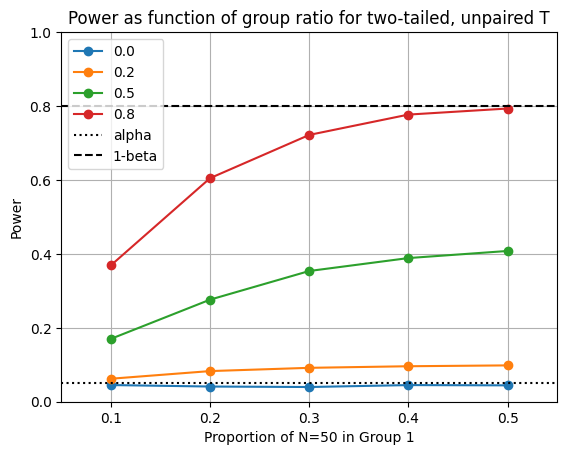

In [51]:
tot_samp_size = 50
df = tot_samp_size - 2
group_ratio = np.arange(0.1, 0.51, 0.1) # Proportion in Group 1
fig, ax = plt.subplots(); 
ax.set_title('Power as function of group ratio for two-tailed, unpaired T'); ax.set_xlabel(f'Proportion of N={tot_samp_size:d} in Group 1')
ax.set_ylabel('Power'); ax.set_xlim(0.05, 0.55); ax.set_ylim(0, 1); ax.grid(True)
#num_samp = int(1e3) # Reduce if uncomment randomisation below and want to save time

pr = np.full((len(group_ratio), len(effect_sizes)), np.nan)
for es, effect_size in enumerate(effect_sizes):
    pop_H1 = pop + effect_size
    for s, ratio in enumerate(group_ratio):
        samp_size1 = round(ratio * tot_samp_size)
        samp_size2 = tot_samp_size - samp_size1
        y1 = sample_pop(pop, samp_size1, num_samp)
        y2 = sample_pop(pop_H1, samp_size2, num_samp)
        p = T2p_2tails(two_t([y1, y2]), df)
        #p = randomise_two_samples([y1, y2], num_rand, two_tailed=True, property='mean')
        #p = randomise_two_samples([y1, y2], num_rand, two_tailed=True, property='tstat')
        pr[s, es] = np.sum(p < alpha) / num_samp

for es, effect_size in enumerate(effect_sizes):
    ax.plot(group_ratio, pr[:, es], 'o-', label=f'{effect_size:.1f}')
ax.axhline(y=alpha, linestyle=':', color='k', label='alpha');
ax.axhline(y=0.8, linestyle='--', color='k', label='1-beta');
ax.legend(loc='upper left');

Note that power decreases as the groups become more unbalanced, though FPR is still controlled (for the T-test). 

You can also try permutation testing of either the mean or the T-statistic itself, by uncommenting the relevant lines above (though it will take a long time to run), and should get similar results. 

### Inhomogeniety of variance: correcting dfs (Welch)
However the variance pooling used by the standard T-test fails when the variance of one group differs from the other. Such "inhomogeniety" of variance is a special case of the more general problem of "nonpshericity" discussed in the GLM section below. 

Indeed, the combination of unequal variance and unequal group sizes is particularly serious for the standard T-test, and can lead to an inflated FPR as we show below. One solution is called Welch's T-test, which does not pool the variance, and reduces the dfs to a fraction of original dfs (an example of Sattherthwaite approximation, to which we will return in the GLM section below). This correction is implemented in the function two_sample_T below:

In [52]:
def two_sample_T(y, type='welch'):
    # Testing mean of Group 2 > mean of Group 1
    
    N = [y[0].shape[0], y[1].shape[0]]   
    if 1 in N:
        type = 'pooled'  
    dm = np.mean(y[1],axis=0) - np.mean(y[0],axis=0)  
    v1 = np.var(y[0], ddof=1, axis=0)
    v2 = np.var(y[1], ddof=1, axis=0)   
    df = sum(N) - 2
    df = np.repeat(df, y[0].shape[1])
    if type == 'unpooled':
        T = dm / np.sqrt(v1/N[0] + v2/N[1])
    elif type == 'pooled':
        sp = ((N[0]-1)*v1 + (N[1]-1)*v2) / df
        T = dm / np.sqrt(sp * (1/N[0] + 1/N[1]))
    elif type == 'welch':
        T = dm / np.sqrt(v1/N[0] + v2/N[1])
        sp = (v1/N[0])**2 / (N[0]-1) + (v2/N[1])**2 / (N[1]-1)
        df = (v1/N[0] + v2/N[1])**2 / sp
    return T, df

Using this, we can illustrate the inhomogeniety of variance problem (for an unbalanced designs) below:

Difference in mean = 0.0
		Variance ratio = 0.5
				Pooled T	(df=48.00),	PR=0.257
				Welchs T	(df=4.47),	PR=0.057
		Variance ratio = 1.0
				Pooled T	(df=48.00),	PR=0.052
				Welchs T	(df=5.99),	PR=0.059
		Variance ratio = 2.0
				Pooled T	(df=48.00),	PR=0.001
				Welchs T	(df=12.09),	PR=0.057
Difference in mean = 0.8
		Variance ratio = 0.5
				Pooled T	(df=48.00),	PR=0.737
				Welchs T	(df=4.48),	PR=0.291
		Variance ratio = 1.0
				Pooled T	(df=48.00),	PR=0.376
				Welchs T	(df=5.97),	PR=0.289
		Variance ratio = 2.0
				Pooled T	(df=48.00),	PR=0.036
				Welchs T	(df=12.28),	PR=0.273


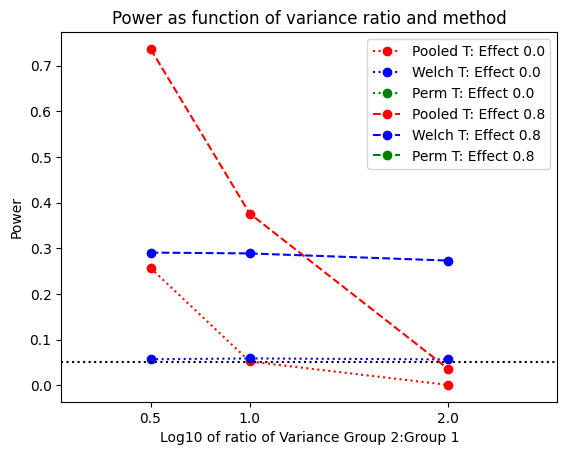

In [53]:
samp_sizes = [5, 45]     # At least one small group
diff_means = [0, 0.8]    # Difference in means
var_ratios = [0.5, 1, 2] # Ratio of variances in Group 2 vs Group 1
num_samp = int(1e4) # reduce if need speed up permutation test below
y = [None, None]
pr = np.full((len(diff_means), len(var_ratios), 3), np.nan) # 3rd argument is method
for es, diff_mean in enumerate(diff_means):
    print(f'Difference in mean = {diff_mean:.1f}')
    for vr, var_ratio in enumerate(var_ratios):
        print(f'\t\tVariance ratio = {var_ratio:.1f}')
        pop_2 = pop * var_ratio + diff_mean
        y[0] = sample_pop(pop,   samp_sizes[0], num_samp)
        y[1] = sample_pop(pop_2, samp_sizes[1], num_samp)
        # Pooled T-test
        T, df = two_sample_T(y, 'pooled')
        p = T2p_2tails(T, df)
        pr[es, vr, 0] = np.sum(p < alpha)/num_samp
        print(f'\t\t\t\tPooled T\t(df={np.mean(df):.2f}),\tPR={pr[es, vr, 0]:.3f}')       
        # Welch's T-test
        T, df = two_sample_T(y, 'welch')
        p = T2p_2tails(T, df)
        pr[es, vr, 1] = np.sum(p < alpha)/num_samp
        print(f'\t\t\t\tWelchs T\t(df={np.mean(df):.2f}),\tPR={pr[es, vr, 1]:.3f}')
        # Permutation test
        #p = randomise_two_samples(y, num_rand, two_tailed=True, property='mean')
        ##p = randomise_two_samples(y, num_rand, two_tailed=True, property='tstat')
        #pr[es, vr, 2] = np.sum(p < alpha)/num_samp
        #print(f'\t\t\t\tPermuted\t(df=N/A),\tPR={pr[es, vr, 2]:.3f}')
fig, ax = plt.subplots(); ax.set_title(f'Power as function of variance ratio and method')
markers = ['ro:', 'ro--', 'bo:', 'bo--', 'go:', 'go--']
labels = []
for q, diff_mean in enumerate(diff_means):
    ax.plot(var_ratios, pr[q, :, 0], markers[q], label=f'Pooled T: Effect {diff_mean:.1f}'); 
    ax.plot(var_ratios, pr[q, :, 1], markers[q+2], label=f'Welch T: Effect {diff_mean:.1f}');
    ax.plot(var_ratios, pr[q, :, 2], markers[q+4], label=f'Perm T: Effect {diff_mean:.1f}');
ax.axhline(y=alpha, color='k', linestyle=':'); labels.append('alpha')
ax.legend(loc='upper right'); ax.set_xlim(0.05, 2.55); #ax.set_ylim(0, 0.8)
ax.set_xticks(var_ratios); ax.set_xlabel('Log10 of ratio of Variance Group 2:Group 1'); ax.set_ylabel('Power'); plt.show()

When there is no effect, the FPR for the pooled T-test is too high when the smaller group is more variable, and too low when the larger group is more variable, whereas the Welch correction (notice the reduced, fractional dfs) maintains FPR close to correct alpha level in all cases. There is a price of this correction though: when variances are homogeneous (ratio of 1), the power to detect a true effect is reduced with the Welch correction (i.e, it is conservative). 

If you uncommment the permutation tests, it will take a while to run, but you should see that FPR is also no longer controlled (even for a pivotal statistic like the pooled variance, two-sample T-statistic) for the cases of unequal variance. This is because the exchangeability criterion is now violated - we cannot simply swap participants between the two groups because the groups are drawn from different populations (differing in their variance). These are situations where parametric tests offer advantages over randomisation testing, in having mathematical (asymptotic) tools that adjust for differences between population distributions (like the Welch correction). Having said that, you could still permute a Welch-corrected T-statistic (not implemented in above randomise_two_samples function) to estimate the p-value. 

## The General Linear Model (GLM)
The T-test is a special case of the General Linear Model (GLM). The GLM is normally expressed as __y = XB+e__, where __y__ is a vector of all data (concatenated across groups), __X__ is a matrix ("design matrix") that specifies the model of the data, __B__ ("Betas") is a vector of the model parameters to be estimated, and __e__ is random error, assumed to be drawn independently from a zero-mean Gaussian (with std estimated when GLM is fit). It can also be written as a set of simultaneous equations y_i = B1 _x_ x1_i + B2 _x_ x2_i... + e_i, for ith observation. Note that, for a unique solution, there should be more datapoints than predictors in the model, i.e. X must be a "tall" matrix with more rows than columns.

### GLM for unpaired T-test
So if we stick with the example of a two-sample, unpaired T-test:

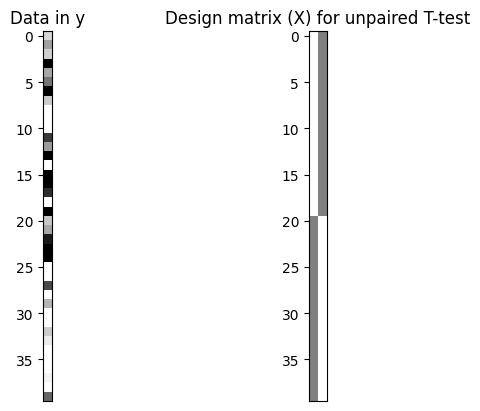

In [54]:
np.random.seed(2) # Initialise random seed
N = [20, 20] 
yg = [None,None]
yg[0] = sample_pop(pop, N[0], 1)
yg[1] = sample_pop(pop, N[1], 1) + 0.5
y = np.concatenate(yg, axis=0)
X = np.concatenate([np.ones((N[0], 1)), np.zeros((N[1], 1))], axis=0)
X = np.concatenate([X, np.concatenate([np.zeros((N[0], 1)), np.ones((N[1], 1))], axis=0)], axis=1)
plt.figure(); plt.subplot(1, 2, 1)
plt.imshow(y, cmap='gray', vmin=-1, vmax=1)
plt.title('Data in y'); plt.xticks([]);
plt.subplot(1, 2, 2); plt.imshow(X, cmap = 'gray', vmin=-1, vmax=1)
plt.title('Design matrix (X) for unpaired T-test'); plt.xticks([]);

The first column of X is a binary, indicator variable that codes which data points come from Group 1, while the second column codes which are from Group 2.

This model can be fit to the data by minimising the squared residuals - so-called "ordinary least squares" (OLS) estimation. Some simple maths shows that this implies that the parameters can be estimated by multiplying the data by the (pseudo)inverse of the design matrix:

In [55]:
B = np.linalg.pinv(X) @ y  # OLS estimate of Betas
print(f'Parameter (Beta) estimates = {B.T[0]}')

Parameter (Beta) estimates = [-0.00354831  0.55715009]


where "B" are estimates of the true parameters. If you examine "pinv(X)", you'll see that it is just estimating the mean for each group in this case. (Technically, one should pre-multiply y by inv(X'*X)*X'- an expression derived from minimising e^2 with respect to B; hence the "least squares" solution - but pinv(X) is more robust for rank-deficient matrices.) 

We can then reconstruct the model fit, the residuals, and estimate the std of the error, given the df:

Estimated std of error = 1.35


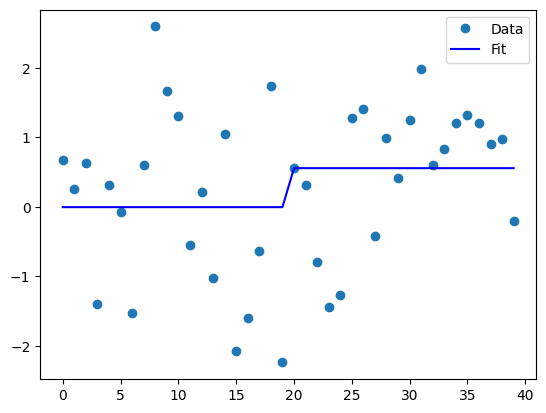

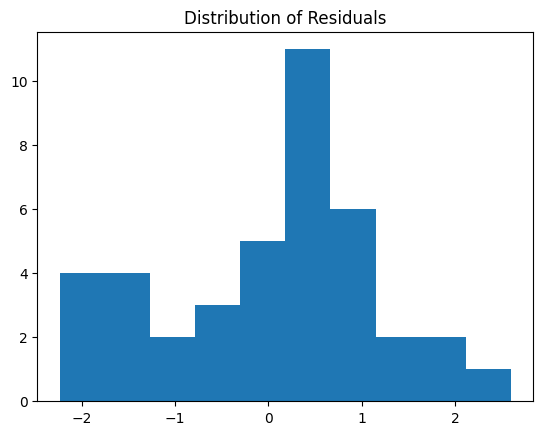

In [56]:
Y = X @ B  # Reconstruct fitted response
r = y - Y  # Residuals
fig, ax = plt.subplots(); ax.plot(y, 'o'); ax.plot(Y, '-b'); ax.legend(['Data', 'Fit']); 
fig, ax = plt.subplots(); ax.hist(r); ax.set_title('Distribution of Residuals');  # residuals consistent with Gaussian error
df = len(y) - np.linalg.matrix_rank(X)
sigma = np.sum(r**2) / df
print(f'Estimated std of error = {sigma:.2f}')

In the case of independent data, the df is the number of data points minus the number of unique parameters estimated, where the latter is the rank of X (the rank of a matrix is the number of linearly independent columns).

The above code can be wrapped into a function "glm_fit":

In [57]:
def glm_fit(y, X):
# Fit GLM design matrix X to data y
    N  = y.shape[0]  # number of data points
    df = N - np.linalg.matrix_rank(X)
    B  = np.linalg.pinv(X) @ y    # Beta estimates
    Y  = X @ B       # Fitted response
    r  = y - Y       # Residuals
    ssr = np.diag(np.atleast_1d(r.T@r)) # Sum of squared residuals
    sigma = ssr / df # Estimate of std of error
    R2  = 1 - ssr / np.diag(np.atleast_1d(y.T@y)) # R^2 effect size (prop. variance explained)
    return B, sigma, R2, r

Having fit the model (and checked the residuals are consistent with assumptions of Gaussian error), we can construct statistics like a T-value, by specifying a "contrast". A contrast is a linear weighting of the parameter estimates, e.g, to test that the mean of Group 2 is bigger than that of Group 1, the contrast would be the vector c = [-1 1].

In [58]:
c = np.array([[-1, 1]]) # Directional T-contrast testing Group 2 mean bigger than Group 1 mean
T = (c @ B) / np.sqrt(sigma*(c @ np.linalg.pinv(X.T@X) @ c.T)) # Equation for T-value
p = T2p_higher(T,df).item()
print(f'P-value from GLM = {p:.3f}')
T, df = two_sample_T(yg,'pooled')
p = T2p_higher(T,df)
print(f'P-value from above T-test = {p[0]:.3f}')

P-value from GLM = 0.067
P-value from above T-test = 0.067


You can see the p-values are identical. Although the equation for the T value looks scary, it is generalising ideas above. We can create a function "glm_con" that performs statistics for a contrast (and a higher level function "glm" that simply calls "glm_fit" followed by "glm_con"):

In [59]:
import scipy as sp

def glm_con(c, X, B, sigma, r=[], nc=0):
# Evaluate contrast c on GLM previously fit to give B, sigma, r
# nc = number of conditions if correcting for nonsphericity (default not)
    if c.ndim == 1:
        c = c[np.newaxis,:] # Ensure contrast is matrix
    c = np.append(c, np.zeros((c.shape[0],X.shape[1]-c.shape[1])), axis=1) # Pad contrast with zeros if needed
    
    N  = X.shape[0]; P = X.shape[1]
    R  = np.eye(N) - X@np.linalg.pinv(X)       # residual forming matrix (full model)
    c0 = np.eye(P) - c.T @ np.linalg.pinv(c.T) # null space of contrast
    X0 = X @ c0                                # reduced model
    R0 = np.eye(N) - X0 @ np.linalg.pinv(X0)   # residual forming matrix (reduced model)
    M  = R0 - R
    
    df = np.empty(2)
    df[0] = np.linalg.matrix_rank(X) - np.linalg.matrix_rank(X0)
    df[1] = N - np.linalg.matrix_rank(X)
 
    if nc > 0: # use residual covariance
        if r.ndim == 1:
            r=r[:,np.newaxis]
        V = np.array([])
        for nt in range(r.shape[1]):
            val = np.reshape(r[:,nt], (nc, int(N/nc))).T
            V = np.stack([V, val]) if V.size else val
        V = np.cov(V, ddof = 1, rowvar=False)
        V = np.kron(V, np.eye(int(N/nc))) 
        # Satterthwaite correction for df
        k = ((np.trace(V)**2)/np.trace(V@V))/df[1]
        df = df*k

    if c.shape[0] == 1: # T-contrast (always directional)
        T = (c @ B) / np.sqrt(sigma*(c @ np.linalg.pinv(X.T@X) @ c.T))
        p = 1 - sp.stats.t.cdf(T, df[1])
        F = T**2
    else: # F-contrast
        F  = ((B.T @ X.T @ M @ X @ B)/df[0]) / ((r.T@r)/df[1])
        if isinstance(F, np.ndarray):
            F = np.diag(F)
        p = 1 - sp.stats.f.cdf(F,df[0],df[1])
        T = []
    return T,F,df,p

In [60]:
def glm(y, X, c, nc=0):
# Simply calls above glm_fit then glm_con
    B, sigma, R2, r = glm_fit(y, X)
    T, F, df, p = glm_con(c, X, B, sigma, r, nc)
    return T,F,df,p,B,R2,r

There are a few more things useful to know about the GLM. Firstly, we nearly always include a constant term in X, which removes the grand-mean across all datapoints. If we add this to our model, note that the dfs do not change, because this new third column is the sum of the first two (ie linearly dependent, ie X has a rank of 2 despite having 3 columns). Thus we get the same p-value:

P-value from GLM with grand mean = 0.067
Parameter (Beta) estimates = [-0.18808224  0.37261617  0.18453393]
Proportion of variance explained by model = 0.108


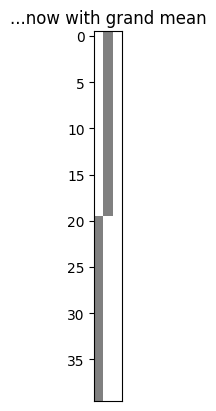

In [61]:
aX = np.append(X, np.ones((np.sum(N),1)), axis=1) # Add grand mean to design matrix
plt.figure(); plt.imshow(aX, cmap='gray', vmin=-1, vmax=1);
plt.title('...now with grand mean'); plt.xticks([]);
B, sigma, R2, r   = glm_fit(y, aX)
T, F, df, p = glm_con(c, aX, B, sigma)
print(f'P-value from GLM with grand mean = {p.item():.3f}')
B = np.array2string(B.T[0])
print(f'Parameter (Beta) estimates = {B}')
print(f'Proportion of variance explained by model = {R2[0]:.3f}')

R2 - the proportion of variance explained - is a measure of overall model fit (and of effect size if hypothesis specified in terms of X). 

Note however that the Bs have changed. This is because the first two now refer to deviations from the grand mean (rather than deviations from zero), ie B1 is what needs to be added to B3 to reproduce the mean of group 1, while B2 is what needs to be added to B3 to reproduce the mean of group 2.

Yet another possibility is to specify the model in terms of two colums of X: one for the difference between conditions and one for the average across condition (the constant term). This is essentially a rotation of original X by the transformation matrix "TM" below, so we can simply apply the same transformation to c to test the equivalent contrast: 

P-value from GLM with grand mean = 0.067
Parameter (Beta) estimates = [0.2803492  0.27680089]
Proportion of variance explained by model = 0.108


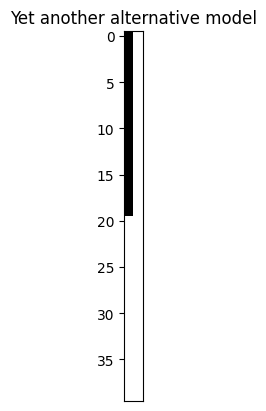

In [62]:
TM = np.array([[-1, 1], [1, 1]]).T   # Transformation Matrix from separate groups to difference and mean across groups
aX = X@TM
plt.figure(); plt.imshow(aX, cmap='gray', vmin=-1, vmax=1)
plt.title('Yet another alternative model'); plt.xticks([]);
B, sigma, R2, r = glm_fit(y, aX)

ac = c@TM  # Since applied TM to X, need to apply to contrast too
T, F, df, p = glm_con(ac, aX, B, sigma)
B = np.array2string(B.T[0])
print(f'P-value from GLM with grand mean = {p.item():.3f}')
print(f'Parameter (Beta) estimates = {B}')
print(f'Proportion of variance explained by model = {R2[0]:.3f}')

Note that p-value and R2 are unchanged from above (because models span the same space). The Bs have again changed, because the first B now refers to how much one needs to add or subtract to the second B to reproduce the two group means respectively.

Note also that the scaling of c does not affect the statistics (though the sign does); nor does scaling of X (e.g, doubling the values in X will halve the values of B, but not affect the T-statistic, since both the numerator and denominator of the T-statistic are scaled by the same amount).

### GLM for paired T-test

We can now illustrate a paired T-test, where we simply add extra columns to X that capture the mean of each participant (note that the "glm_con" function pads any contrast vector c with 0's for any extra columns of X not included in the contrast vector provided):

Paired GLM: T(19)=4.24, p=0.000224
Unpaired GLM: T(38)=1.6, p=0.0593


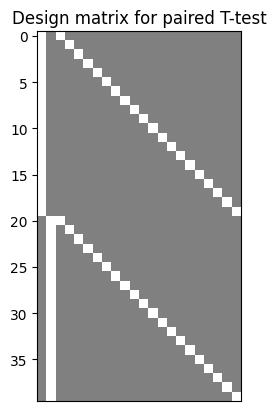

In [63]:
N = 20
yg[0] = sample_pop(pop, N, 1);
yg[1] = yg[0] + np.random.randn(N,1)/2 + 0.5 # add signal with correlated effects across participants
y = np.concatenate(yg, axis=0)
X = np.append(np.kron(np.eye(2),np.ones((N,1))), np.kron(np.ones((2,1)),np.eye(N)), axis=1)
plt.figure(); plt.imshow(X, cmap='gray', vmin=-1, vmax=1);
plt.title('Design matrix for paired T-test'); plt.xticks([]);

T,F,df,p,B,R2,r = glm(y, X, c)
print(f'Paired GLM: T({int(df[1])})={T.item():.3}, p={p.item():.3}')

T,F,df,p,B,R2,r = glm(y, X[:,:2], c[:,:2])
print(f'Unpaired GLM: T({int(df[1])})={T.item():.3}, p={p.item():.3}')

Note again the smaller p-value for the paired than unpaired model, because its extra columns are capturing additional variance in the data, hence the residuals are smaller, and hence the T-value is higher, which often outweighs the loss in dfs (to the extent that there is between-participant variance in the data, as there is in above case since the data for condition 2 share a contribution from those in condition 1).

**Exercise: convince yourself that the above paired T-test can be reduced to a one-sample T-test within the GLM. Hint apply __TM = np.kron([-1, 1],np.eye(N))__ to X and c (noting that the GLM still works even though X is rank deficient, though you could also reduce __X@TM__ to just its second column, and adjust contrast __c__ to just [1]).**

## ANOVA and F-tests
We now turn to experiments with more than two conditions, which are often analysed with "Analysis of Variance" (ANOVA) (thanks again to Fisher). In such cases, we may be interested in any differences between three or more conditions; a hypothesis that cannot be tested with a T-statistic, but can be tested with the F-statistic. 

Calculation of the F-statistic within the GLM is a bit complex (see "glm_con"), but can be throught as comparing the variance explained by two models: the full model (with the effects of interest) relative to a reduced model (without effects of interest), where the effects of interest are specified by an F-contrast. Whereas the contrast vector c for a T-contrast is always one-dimensional (one row), an F-contrast can have more than one row (i.e., becomes a contrast matrix). This is easiest to explain with the concept of a 1x3 repeated-measures ("within-participant") ANOVA:

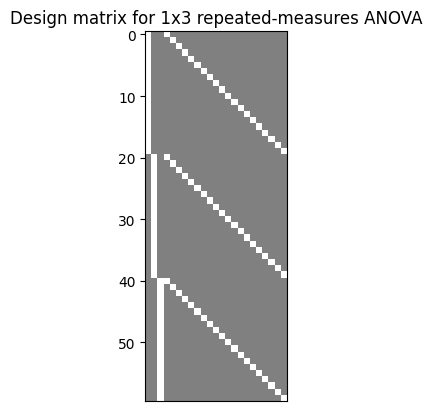

In [64]:
nc = 3 # Number of conditions
X = np.append(np.kron(np.eye(nc),np.ones((N,1))), np.kron(np.ones((nc,1)),np.eye(N)), axis=1)
plt.figure(); plt.imshow(X, cmap='gray', vmin=-1, vmax=1);
plt.title('Design matrix for 1x3 repeated-measures ANOVA'); plt.xticks([]);

We are now also going to generate data using a multivariate normal distribution (as if we had sampled the same person in a population several times), in which we can specify the correlation between measures from the same people (the variable "ppt_cor" below, the size of which determines how much more efficient within-participant designs can be; a parameter also often needed for power analyses):

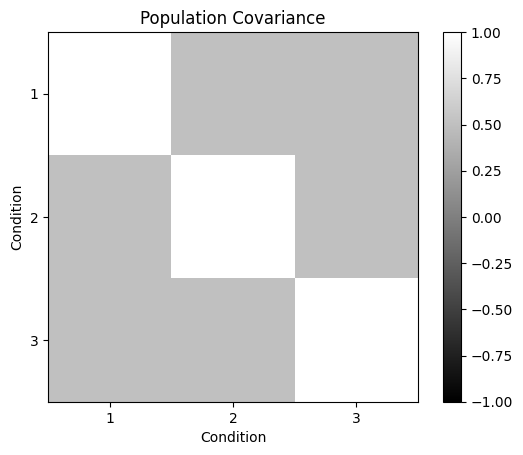

In [65]:
np.random.seed(1) # Initialise random seed
pop_means = np.array([1, 2, 3])/nc # Means across 3 conditions
ppt_cor = 0.5 # correlation between measures from same participants
pop_cov = np.ones((nc,nc))*ppt_cor + (1-ppt_cor)*np.eye(nc) # covariance matrix
plt.figure(); plt.imshow(pop_cov, cmap='gray', vmin=-1, vmax=1);
plt.title('Population Covariance'); plt.xticks([0,1,2],labels=[1,2,3]); plt.yticks([0,1,2],[1,2,3])
plt.xlabel('Condition'); plt.ylabel('Condition'); plt.colorbar();
y = np.random.multivariate_normal(pop_means, pop_cov, N) # Generate correlated data
y = np.concatenate(y.T,axis=0) # Concatenate (from "wide" to "long" format)

If we want to test whether the means of the three conditions differ in any way, we can specify an F-contrast with any of the contrast matrices below (which are all equivalent, and have same rank):

In [66]:
print('Equivalent F-contrasts:')
print('Does condition 1 differ from 2, and/or condition 2 from 3?')
c = np.array([[1, -1, 0], [0, 1, -1]]); print(c)     
print('Does any condition differ from average of other two?')
c = np.array(sp.signal.detrend(np.eye(3),axis=0,type='constant')); print(c)
print('Orthonormal contrast (generally safest)')
c,_ = np.linalg.qr(np.diff(np.eye(3), axis=0).T); c = c.T; print(c)

Equivalent F-contrasts:
Does condition 1 differ from 2, and/or condition 2 from 3?
[[ 1 -1  0]
 [ 0  1 -1]]
Does any condition differ from average of other two?
[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]
Orthonormal contrast (generally safest)
[[-0.70710678  0.70710678  0.        ]
 [-0.40824829 -0.40824829  0.81649658]]


We'll just create a little function to create orthonormal contrasts for generic ANOVAs later:

In [67]:
def ortho_con(N): 
    c,_ = np.linalg.qr(np.diff(np.eye(N), axis=0).T)
    return(c.T)

Note also that, whereas T-tests (within GLM) are always directional, F-contrasts are always non-directional, and the sign of the contrast weights does not matter. Indeed, for 1D case, F=T^2, equivalent to a two-tailed T-test. As with a T-contrast, the scaling of the weights within each row does not matter, though that scaling does need to be the same across rows. One way to think about an F-contrast is as the union of effects in each row, e.g, for the first contrast above, asking whether conditions 1 and 2 differ AND/OR whether conditions 2 and 3 differ. Or in geometric terms, for a 2D design matrix, you can think of a T-test as testing the distance along the projection of the data onto one direction through that 2D space, whereas the F-test is testing the distance from the origin, i.e, a circular exclusion zone.

The distribution of the F-statistic is determined by two dfs: the numerator df refers to the (dimensionality/rank of) the effects of interest, as specified by the F-contrast (with value 2 for examples above), whereas the denominator df refers to the remaining dfs in the data. A p-value can then be calculated from the parametric distribution of the F-statistic:

In [68]:
T,F,df,p,B,R2,r = glm(y, X, c)
print(f'Main effect in 1x3 ANOVA: F({int(df[0])},{int(df[1])})={F.item():.3f}, p={p.item():.3f}')

Main effect in 1x3 ANOVA: F(2,38)=3.397, p=0.044


**Exercise: how can one test for a linear effect across three conditions? You might think a contrast [-1 0 1] on above design matrix will do this, but this only compares the two extreme levels, i.e, could return a significant positive effect even if the means of the data were [1 -3 2]. The solution is to fit a more restricted model in which the first three columns of X are replaced with a single column capturing only a linear effect, ie by setting X = np.append(X[:,:3] @ np.array([[-1],[0],[1]]), X[:,3:]) and testing a contrast c = [1] (np.ones((1,1))).**

### Nonsphericity (inhomogeniety of error (co)variance)

However there are situations in which the above p-values can be incorrect (ie FPR too high). Above we stated that the GLM assumes the error is drawn independently from a single Gaussian. This assumption is sometimes described as the residuals being "white", or "independent and identically distributed" (IID). In fact, the more precise assumption for these ANOVA designs is that the error covariance across conditions is "spherical". Sphericity is complicated to define, but a common case that meets sphericity is that the covariance matrix has "compound symmetry", which means that all the diagonal values are equal (homogeniety of variance, or heteroscedasticity) and all the off-diagonal values are equal (homogeniety of covariance). The pop_cov matrix above is compound symmetric, and the simulations below confirm that the FPR is controlled. But notice what happens between when either homogeniety of variance (as we met above in case of unpaired T-tests) or homogeniety of covariance are not met:

In [69]:
np.random.seed(2) # Initialise random seed
num_samp = int(1e3)
p = np.empty((num_samp,3))
for s in range(num_samp):
    # 1. compound symmetry
    pop_cov = [[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]] 
    y = np.random.multivariate_normal(np.zeros(3), pop_cov, N)
    y = np.concatenate(y.T,axis=0)  
    T,F,df,pval,B,R2,r = glm(y, X, c)
    p[s,0] = pval.item()

    # 2. inhomogeniety of covariance
    pop_cov = [[1, 0.8, 0.4], [0.8, 1, 0.8], [0.4, 0.8, 1]] 
    y = np.random.multivariate_normal(np.zeros(3), pop_cov, N)
    y = np.concatenate(y.T,axis=0)
    T,F,df,pval,B,R2,r = glm(y, X, c)
    p[s,1] = pval.item()

    # 3. inhomogeniety of variance
    pop_cov = [[0.1, 0, 0], [0, 1, 0], [0, 0, 10]] 
    y = np.random.multivariate_normal(np.zeros(3), pop_cov, N)
    y = np.concatenate(y.T,axis=0)
    T,F,df,pval,B,R2,r = glm(y, X, c)
    p[s,2] = pval.item()

fpr = np.sum(p < alpha, axis=0) / num_samp
print(f'Compound symmetric covariance, FPR={fpr[0]:.3f}')
print(f'Inhomogeniety of covariance,   FPR={fpr[1]:.3f}')
print(f'Inhomogeniety of variance,     FPR={fpr[2]:.3f}')

Compound symmetric covariance, FPR=0.047
Inhomogeniety of covariance,   FPR=0.079
Inhomogeniety of variance,     FPR=0.084


Only the first example controls FPR at alpha, while FPR is elevated for the other two cases (the second example of inhomogeniety of covariance resembles the autocorrelation when y is a timeseries, as discussed later). A common way to correct for this nonsphericity is to adjust (reduce) the dfs, as we saw earlier in Welch's correction for inhomogeneous variances. The general approach uses what is called the Satterthwaite approximation (but variants include Greenhouse-Geisser or Huyn-Feldt). You can test this by passing a fourth argument to "glm", which tells it how many conditions of interest there are. This estimates the covariance across conditions from the residuals, and reduces the dfs accordingly. 

**Exercise: add the number of conditions as an additional argument to glm above, eg "glm(y, X, c, 3)", and you should see the FPR is now better controlled in all cases.**

### Factorial designs

Often experimental conditions are generated by a factorial design, where each condition corresponds to one level of each of multiple factors. For example, a design with two factors each with two levels would have 4 conditions, and corresponds to "2x2 ANOVA". Factorial designs are associated with a common set of contrasts (hypotheses): main effects of each factor plus interactions between them. For example, if we have factor F1 with levels A and B, and factor F2 with levels 1 and 2, and we order the four conditions in X as [A1 A2 B1 B2], then: 

In [70]:
c1 = np.kron([-1, 1], [1,  1])
print(f'Main effect of F1: \t\t{c1}')
c2 = np.kron([1,  1], [-1, 1])
print(f'Main effect of F2: \t\t{c2}') 
c3 = np.kron([-1, 1], [-1, 1])
print(f'Interaction between F1 and F2: \t{c3} (difference of differences)') 

Main effect of F1: 		[-1 -1  1  1]
Main effect of F2: 		[-1  1 -1  1]
Interaction between F1 and F2: 	[ 1 -1 -1  1] (difference of differences)


More generally, all possible main effects and interactions in a factorial design can be generated by the Kronecker product of two contrasts for each factor f with P[f] levels: 1) "np.ones(P[f])" for the common effect across levels, and 2) the orthonormal contrast for the difference between levels, as defined in the F-contrasts section above, eg: 

In [71]:
P = [2, 3] # 2 x 3 ANOVA
m = []; d = []
for f in range(len(P)):
    m.append(np.ones(P[f]))
    d.append(ortho_con(P[f]))
print('Example of main effect of second factor in 2x3 design:')
c = np.kron(m[0],d[1]); print(c) 
print('Example of interaction between two factors in 2x3 design:')
c = np.kron(d[0],d[1]); print(c)

Example of main effect of second factor in 2x3 design:
[[-0.70710678  0.70710678  0.         -0.70710678  0.70710678  0.        ]
 [-0.40824829 -0.40824829  0.81649658 -0.40824829 -0.40824829  0.81649658]]
Example of interaction between two factors in 2x3 design:
[[ 0.5        -0.5        -0.         -0.5         0.5         0.        ]
 [ 0.28867513  0.28867513 -0.57735027 -0.28867513 -0.28867513  0.57735027]]


_Interesting factoid: Leonold Kronecker's famous saying was "Die ganzen Zahlen hat der liebe Gott gemacht, alles andere ist Menschenwerk" ("God made the integers, all else is the work of man")_

### Pooled vs partitioned error
When all conditions are between-participant (i.e., each condition is a group), we can have a single X with as many columns as there are groups, within which we can evaluate every ANOVA F-contrast like above. We do not have to worry about inhomogeniety of covariance (because true covariances are 0 when participants are assumed to be independent), though we should worry about inhomogeniety of variance (using the Satterthwaite approximation mentioned above).  

When one or more factors are within-participant, however, we have possible inhomogeniety of covariance too. One way to reduce this nonsphericity problem is to "partition" the error into separate error terms for each ANOVA effect (rather than the "pooled" error used so far). Because the columns in X for ANOVA designs are orthogonal (as are the rows of orthonormal F-contrasts for each ANOVA effect), we can effectively fit a separate (reduced) design matrix for each ANOVA effect by pre-muliplying the data by these F-contrasts. This is illustrated before for a 2x2 design in which both factors are within-participant:

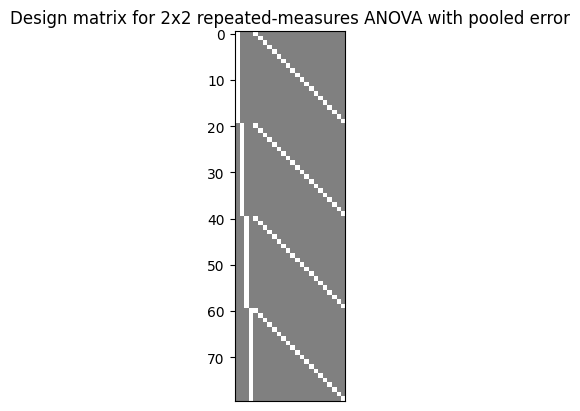

In [72]:
np.random.seed(1) # Initialise random seed
nc = 4; N = 20
X = np.append(np.kron(np.eye(nc),np.ones((N,1))), np.kron(np.ones((nc,1)),np.eye(N)), axis=1)
plt.figure(); plt.imshow(X, cmap='gray', vmin=-1, vmax=1);
plt.title('Design matrix for 2x2 repeated-measures ANOVA with pooled error'); plt.xticks([]);

In [73]:
es = np.array([3, 2, 1])/3 # Effect sizes for main effects and interaction (not standardised effect sizes though!)
pop_means = es @ np.array([c1, c2, c3])/4 # Project to conditions using ANOVA contrasts above
#pop_cov = np.ones((4,4))*ppt_cor + (1-ppt_cor)*np.eye(4) # covariance matrix
pop_cov = [[1, 0.8, 0, 0], [0.8, 1, 0, 0], [0, 0, 0.5, 0.3], [0, 0, 0.3, 0.5]] # nonspherical case
y = np.random.multivariate_normal(pop_means, pop_cov, N) # Generate correlated data
y = np.concatenate(y.T,axis=0)

# Pooled error (using c1-c3 effect contrasts from above)
B, sigma, R2, r = glm_fit(y, X)
T, F, df, p = glm_con(c1, X, B, sigma, r, nc)
print(f'Contrast {c1}, F({df[0].item():.3f}, {df[1].item():.3f}) = {F.item():.3f}, pooled p={p.item():.3f}')
T, F, df, p = glm_con(c2, X, B, sigma, r, nc)
print(f'Contrast {c2}, F({df[0].item():.3f}, {df[1].item():.3f}) = {F.item():.3f}, pooled p={p.item():.3f}')
T, F, df, p = glm_con(c3, X, B, sigma, r, nc)
print(f'Contrast {c3}, F({df[0].item():.3f}, {df[1].item():.3f}) = {F.item():.3f}, pooled p={p.item():.3f}')
print('\n')

# Partitioned error (using c1-c3 effect contrasts from above)
c = np.kron(c1,np.eye(N))
Xc = np.ones((N,1)) # Here one-sample T-test; more generally Xc = c@X
B, sigma, R2, r = glm_fit(c@y, Xc)
T, F, df, p = glm_con(np.array([1]), Xc, B, sigma, r)
print(f'Contrast {c1}, F{int(df[0]), int(df[1])} = {F.item():.3f}, partitioned p={p.item():.3f}')
c = np.kron(c2,np.eye(N))
B, sigma, R2, r = glm_fit(c@y, Xc)
T, F, df, p = glm_con(np.array([1]), Xc, B, sigma, r)
print(f'Contrast {c2}, F{int(df[0]), int(df[1])} = {F.item():.3f}, partitioned p={p.item():.3f}')
c = np.kron(c3,np.eye(N))
B, sigma, R2, r = glm_fit(c@y, Xc)
T, F, df, p = glm_con(np.array([1]), Xc, B, sigma, r)
print(f'Contrast {c3}, F{int(df[0]), int(df[1])} = {F.item():.3f}, partitioned p={p.item():.3f}')

Contrast [-1 -1  1  1], F(0.533, 30.363) = 13.658, pooled p=0.000
Contrast [-1  1 -1  1], F(0.533, 30.363) = 5.446, pooled p=0.013
Contrast [ 1 -1 -1  1], F(0.533, 30.363) = 2.040, pooled p=0.082


Contrast [-1 -1  1  1], F(1, 19) = 5.809, partitioned p=0.013
Contrast [-1  1 -1  1], F(1, 19) = 18.551, partitioned p=0.000
Contrast [ 1 -1 -1  1], F(1, 19) = 5.743, partitioned p=0.014


The p-values from the pooled error are sometimes smaller, due to larger dfs, but those from the partitioned approach are safer because the error covariance matrix is smaller (since fewer conditions per model), so sphericity assumptions more likely to be met (indeed, when there are only 2 levels per factor, as here, the GLM only has one column and hence one covariance term, so the error must be spherical by definition). 

**Exercise: if you want to check robustness of partitioned error to nonspheriricty, run above code over num_samp studies to calculate FPR**

Note permutation testing is possible with these more complex ANOVA models, but can be tricky because the exchangeability requirement restricts how exactly participants can be swapped between conditions. Indeed, for the case of timeseries considered below, where every datapoint can be dependent on others, randomisation is very tricky (though one can phase-shuffle data while maintaining the power spectrum, i.e, autocorrelation). By contrast, the strength of the parametric assumptions of the GLM comes with the flexibility they afford, as exemplified below.

### Continuous regressors (multiple regression)

So far we have applied the GLM to experiments with one or more conditions, in which the values in X are binary, but it can equally be applied to continuous values in X, e.g, to perfom multiple regression. The simplest example of this is to estimate the correlation between two variables:

Pearson correlation, R(20)=0.32, p=0.164
GLM F-test, F(1, 18) = 2.101, p=0.164 (R2=0.71)


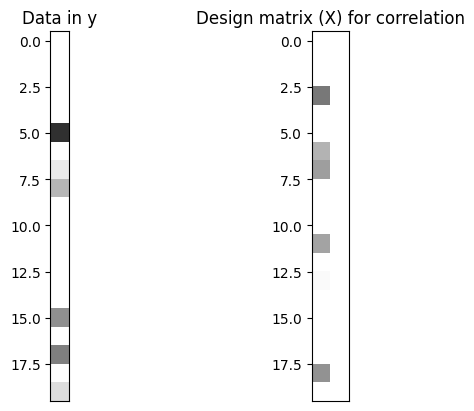

In [74]:
np.random.seed(2) # Initialise random seed
pop_cov = np.ones(2)*ppt_cor + (1-ppt_cor)*np.eye(2) # covariance matrix
y = np.random.multivariate_normal(np.ones(2), pop_cov, N) # Mean of 1

Rp = sp.stats.pearsonr(y[:,0], y[:,1]) # Pearson correlation
print(f'Pearson correlation, R({N})={Rp[0]:.2f}, p={Rp[1]:.3f}')

X = np.append(y[:,1][:,np.newaxis], np.ones((N,1)),axis=1)
T,F,df,p,B,R2,r = glm(y[:,0], X, np.array([1,0]))
p = p*2 # GLM T-test one-tailed by default, so double for two-tailed
print(f'GLM F-test, F{int(df[0]), int(df[1])} = {F.item():.3f}, p={p.item():.3f} (R2={R2[0].item():.2f})') 

plt.figure(); plt.subplot(1, 2, 1)
plt.imshow(y[:,0][:,np.newaxis], cmap='gray', vmin=-1, vmax=1)
plt.title('Data in y'); plt.xticks([]);
plt.subplot(1, 2, 2); plt.imshow(X, cmap = 'gray', vmin=-1, vmax=1)
plt.title('Design matrix (X) for correlation'); plt.xticks([]);

The F-contrast on first column of X gives same p-value as standard Pearson correlation. Note that it is important to include the second, constant term in X, to remove the mean (if you do not include it, and the means of y(:,1) and y(:,2) are not zero, then the p-value will not correspond to a correlation, but include the effect of the means). You will also note that the sqrt(R2) does not equal the Pearson correlation coefficient Rp. This is because R2 above refers to whole model fit, including mean. To estimate the Pearson correlation coefficient, you could mean-correct y:

In [75]:
#my = y - np.repeat(np.mean(y, axis=0), y.shape[0], axis=0)  # mean-correct y
my = sp.signal.detrend(y,axis=0,type='constant')
T,F,df,p,_,R2,r = glm(my[:,[0]], my[:,[1]], np.array([1]))
p = p*2 # If contrast vector 1d, GLM assumes (one-tailed) T-test, so double to get (two-tailed) p-value for F-test
R2 = R2[0].item()
R = np.sqrt(R2)
print(f'GLM: R2={R2:.2f}, R={R:.2f}, F{int(df[0]), int(df[1])}={F.item():.3f}, p={p.item():.3f}') 

GLM: R2=0.10, R=0.32, F(1, 19)=2.218, p=0.153


(though there are other ways of calculating R2 from sub-spaces of X specified by the contrast). While we have now recovered the Pearson coefficient, note that the p-value is no longer quite correct, because we removed df's from the data when we mean-corrected, but not told the model about this. This is why it is generally best not to perform any operations on the data (like mean-correction) before entering them into the GLM; rather you should include such operations in the GLM if possible (e.g, adding a constant term, or filter the model if also filtering the timeseries, see later).

_Interesting factoid: Karl Pearson made many contributions to statistics, though like his colleague Fisher, he was tarred by his views on eugenics. However, correlation is not causation, and statistical training does not necessarily result in eugenic beliefs._

We can plot the fit and data from the original example above:

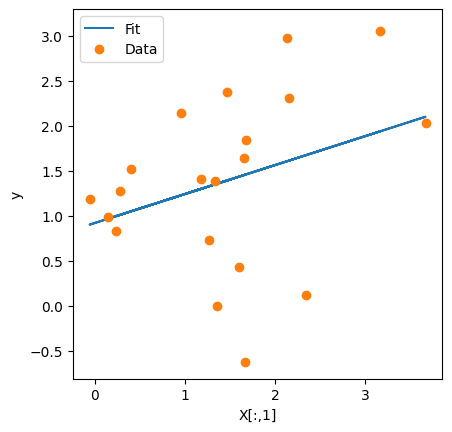

Parameter estimates from original GLM above: B1=0.32, B2=0.92


In [76]:
Y = X @ B  # Reconstruct fitted response
plt.figure()
plt.plot(X[:, 0], Y, '-', label='Fit')
plt.plot(y[:, 1], y[:, 0], 'o', label='Data')
plt.legend(); plt.axis('square')
ax = plt.gca()
#ax.spines['left'].set_position('zero'); ax.spines['left'].set_color('none')
#ax.spines['bottom'].set_position('zero'); ax.spines['bottom'].set_color('none')
plt.ylabel('y'); plt.xlabel('X[:,1]')
plt.show()
print(f'Parameter estimates from original GLM above: B1={B[0]:.2f}, B2={B[1]:.2f}')

You can see that B1 corresponds to the slope of the fit (regression line), whereas B2 is the intercept (value expected when variable in X(:,1) is zero). What happens if we mean-correct X(:,1): 

In [77]:
mX = X.copy()
mX[:, 0] = X[:, 0] - np.mean(X[:, 0])
T,F,df,p,mB,R2,r = glm(y[:,0], mX, np.array([1, 0]))
p = p*2 # If contrast vector 1d, GLM assumes (one-tailed) T-test, so double to get (two-tailed) p-value for F-test
print(f'GLM F-test, F({int(df[0])},{int(df[1])})={F.item():.2f}, p={p.item():.3f}')
print(f'Parameter estimates after mean-correction: B1={mB[0]:.2f}, B2={mB[1]:.2f}')
print(f'Mean of data={np.mean(y[:, 0]):.2f}')

GLM F-test, F(1,18)=2.10, p=0.164
Parameter estimates after mean-correction: B1=0.32, B2=1.38
Mean of data=1.38


You can see that B1 (the slope) has not changed (and nor have the statistics), but B2 has, and it now reflects the mean of the data, not the intercept. This is a special case of orthogonalising regressors, to which we now turn.

### Correlated Regressors and Orthogonalisation
Let's now fit the data will two continuous regressors, but make them highly correlated:  

In [78]:
np.random.seed(2) # Initialise random seed
pop_cov = [[1, 0.5, 0.5], [0.5, 1, 0.9], [0.5, 0.9, 1]] # covariance matrix
N = 30
y = np.random.multivariate_normal(np.ones(3), pop_cov, N) # Mean of 1

If we fit each regressor separately, the p-value is usually small:

In [79]:
T,F,df,p,B,R2,r = glm(y[:,[0]], np.append(y[:,[1]], np.ones((N,1)), axis=1), np.array([1]))
print(f'Separate GLM T-test for 1st regressor T({int(df[1])}) = {T.item():.3f}, p={p.item():.3f}')
T,F,df,p,B,R2,r = glm(y[:,[0]], np.append(y[:,[2]], np.ones((N,1)), axis=1), np.array([1]))
print(f'Separate GLM T-test for 2nd regressor T({int(df[1])}) = {T.item():.3f}, p={p.item():.3f}')  

Separate GLM T-test for 1st regressor T(28) = 3.006, p=0.003
Separate GLM T-test for 2nd regressor T(28) = 2.731, p=0.005


However, when we add both to the same model:

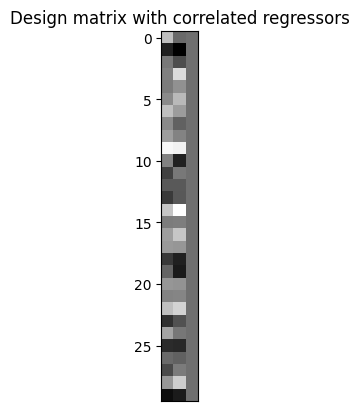

In [80]:
X = np.append(y[:,1:3], np.ones((N,1)), axis=1)
plt.figure(); plt.imshow(X, cmap='gray');
plt.title('Design matrix with correlated regressors'); plt.xticks([]);

In [81]:
T,F,df,p,B,R2,r = glm(y[:,[0]], X, np.array([1, 0, 0]))
print(f'Joint GLM T-test for 1st regressor T({int(df[1])}) = {T.item():.3f}, p={p.item():.3f}')
T,F,df,p,B,R2,r = glm(y[:,[0]], X, np.array([0, 1, 0]))
print(f'Joint GLM T-test for 2nd regressor T({int(df[1])}) = {T.item():.3f}, p={p.item():.3f}')  

Joint GLM T-test for 1st regressor T(27) = 1.365, p=0.092
Joint GLM T-test for 2nd regressor T(27) = 0.798, p=0.216


...rarely is either individual regressor significant. This is because the parameter estimates from a GLM only reflect the unique variance explained by each regressor. Note however that an F-test across both regressors produces a significant result because it includes the shared variance:

In [82]:
T, F, df, p = glm_con(np.array([[1, 0, 0], [0, 1, 0]]).T, X, B, sigma, r) 
print(f'Joint GLM F-test for 1st and 2nd regressor, F{int(df[0]), int(df[1])}={F.item():.3}, p={p.item():.3}')

Joint GLM F-test for 1st and 2nd regressor, F(2, 27)=4.78, p=0.0167


Sometimes people orthogonalise one regressor with respect to the other. This can be done with the "orthog" function below (which actually just residualises one regressor by fitting a GLM that predicts it by the other). So let's orthogonalise the first regressor with respect to the second:

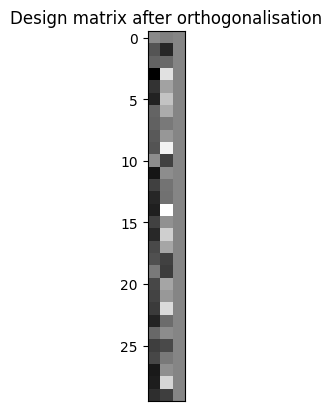

In [83]:
orthog = lambda x,y: x - y @ np.linalg.pinv(y) @ x # orthogonalise x with respect to y

oX = X.copy()
oX[:,[0]] = orthog(X[:,[0]], X[:,[1]]) # orthogonalise 1st regressor with respect to 2nd
plt.figure(); plt.imshow(oX, cmap='gray');
plt.title('Design matrix after orthogonalisation'); plt.xticks([]);

In [84]:
print(f'Previous Betas: \t\t{np.ndarray.flatten(B)}')
T,F,df,p,B,R2,r = glm(y[:,[0]], oX, np.array([1, 0, 0]))
print(f'Betas after orthogonalisation: \t{np.ndarray.flatten(B)}')
print(f'Orthog GLM T-test for 1st regressor T({int(df[1])}) = {T.item():.3f}, p={p.item():.3f}')
T,F,df,p,B,R2,r = glm(y[:,[0]], oX, np.array([0, 1, 0]))
print(f'Orthog GLM T-test for 2nd regressor T({int(df[1])}) = {T.item():.3f}, p={p.item():.3f}')

Previous Betas: 		[ 0.63908908  0.30726968 -0.26499199]
Betas after orthogonalisation: 	[ 0.63908908  0.87230875 -0.26499199]
Orthog GLM T-test for 1st regressor T(27) = 1.365, p=0.092
Orthog GLM T-test for 2nd regressor T(27) = 3.091, p=0.002


As with mean-correction in the previous examine of correlations, the Beta and p-value for the regressor that has been orthogonalised (B1) does not change, but those for the other regressor do, because now the common variance between the two has been assigned to it. However, there is no magic here - in general, one cannot know how to assign common variance to two or more correlated variables - there should always be an independent reason for giving priority to one over another. (Sometimes, in unbalanced ANOVA designs in which the columns of X are no longer orthogonal, priority is given to lower-order effects, e.g. main effects over interactions. This corresponds to differences between "Type I, II and III sum of squares"; which are effectively just different orders of orthogonalisation.)

Finally, note that sometimes the GLM regressors are Z-scored; again, this does not affect tests of the significance of individal parameter estimates (when there is a constant term in X), but the scaling by their std does affect their Betas, and hence any contrasts between those Betas (and this is often important, in order to put the parameters onto the same scale, ie make them commensurate, if they do not already have meaningful units of comparison).

### Efficiency

Importantly, high correlation between regressors in a GLM reduces the power with which their unique contributions (parmeters) can be estimated. It does not bias the parameter estimates or statistical tests on them (e.g., when data is generated from a weighted combination of both of them); it just makes those estimates (weights) highly variable across experiments (i.e. different data samples). Indeed, the correlation between regressors is inherent to the definition of the efficiency of a GLM to test a specific hypothesis, which is a function of the design matrix and contrast:

In [85]:
efficiency = lambda X,c: np.trace(c @ np.linalg.inv(X.T @ X) @ c.T)**-1 # scaling arbitrary

High correlation between columns of X reduces the middle term in this equation. Note however that the contrast itself also matters, so it may not matter if regressors are (negatively) correlated, if one only cares about the difference between them, as in the example below, where efficiency for the difference between the slopes of two regressors is much higher than that for their average slope: 

In [86]:
np.random.seed(1) # Initialise random seed
pop_cov = [[1, -0.5], [-0.5, 1]] # covariance matrix
X = np.random.multivariate_normal(np.ones(2), pop_cov, N) 
X = np.append(X, np.ones((N,1)), axis=1)
c = np.array([[1, 1, 0]])
print(f'Efficiency of Contrast {np.ndarray.flatten(c)} = {efficiency(X,c):.3f}')
c = np.array([[1, -1, 0]])
print(f'Efficiency of Contrast {np.ndarray.flatten(c)} = {efficiency(X,c):.3f}')

Efficiency of Contrast [1 1 0] = 6.883
Efficiency of Contrast [ 1 -1  0] = 14.681


Or in the extreme case, the columns of a two-sample T-test are perfectly anti-correlated, which means one cannot estimate one condition independently of the other (when a constant term is included), and efficiency above is not defined, but one can still estimate the difference between the two conditions.

**Exercise (advanced): this definition of efficiency is helpful when comparing different fMRI designs, where the effects of correlations between regressors induced by the HRF and by the onsets of different conditions is difficult to intuit. You could try estimating efficiency for variants of the fMRI GLM below (taking care to match the scaling of X and c). More generally, this webpage explains how to design efficient fMRI experiments: https://imaging.mrc-cbu.cam.ac.uk/imaging/DesignEfficiency**

### Nonlinear effects

Finally, we are assuming a linear relationship between y and (each regressor in) X. In general the relationship could be nonlinear, and while there are several ways of modelling this, the simplest approach is through a polynomial expansion, as defined here:

In [87]:
def polynom(x, n, z=1, o=1):   
    # Return polynomial expansion of data matrix x to order n
    # (each order orthogonalised wrt lower orders, and normalised by std)
    
    if n > N:
        raise ValueError(f"{n}th order expansion not possible for only {N} points")

    X = np.ones((N, 1))  # 0th order (intercept)

    for p in range(1, n+1):
        for q in range(x.shape[1]):
            d = x[:, q]
            nX = d ** p
            if o == 1:
                nX = orthog(nX, X)
            if p > 0 and z == 1:
                nX = nX / np.std(nX)
            X = np.append(X, nX[:,np.newaxis], axis=1)
    return X

(Here there is a good reason to orthogonalise higher order terms with respect to lower order ones, ie to assign any shared variance to lower order terms). This example detects a pure quadratic relationship between y and the original variable x:

0th-order (intercept) effect, T(27)=0.97, p=0.17
1st-order (linear) effect, T(27)=-2.22, p=0.983
2nd-order (quadratic) effect, T(27)=7.09, p=6.4e-08
F-test for overall effect, F(3, 27)=18.7, p=9.12e-07


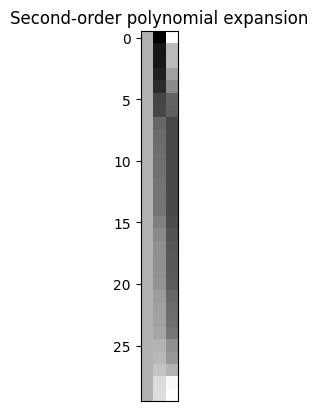

In [88]:
x = np.sort(X[:,[0]], axis=0) # Sort first regressor from above to aid visualisation
# Create pure quadratic effect plus noise
y = sp.signal.detrend(x,axis=0,type='constant')**2 # remove mean first
y = sp.signal.detrend(y,axis=0,type='constant') # remove mean after
y = y + np.random.randn(N,1)

X = polynom(x,2)
plt.figure(); plt.imshow(X, cmap='gray');
plt.title('Second-order polynomial expansion'); plt.xticks([]);

T,F,df,p,B,R2,r = glm(y, X, np.array([1, 0, 0]))
print(f'0th-order (intercept) effect, T({int(df[1])})={T.item():.3}, p={p.item():.3}')
T,F,df,p,B,R2,r = glm(y, X, np.array([0, 1, 0]))
print(f'1st-order (linear) effect, T({int(df[1])})={T.item():.3}, p={p.item():.3}')
T,F,df,p,B,R2,r = glm(y, X, np.array([0, 0, 1]))
print(f'2nd-order (quadratic) effect, T({int(df[1])})={T.item():.3}, p={p.item():.3}')
T,F,df,p,B,R2,r = glm(y, X, np.eye(3))
print(f'F-test for overall effect, F{int(df[0]), int(df[1])}={F.item():.3}, p={p.item():.3}')

The first three T-tests test for constant, linear and quadratic effects respectively, while more common is the final F-test, which captures *any* dependency between y and the original variable x, at least to second-order.

More generally, there are generalisations of the GLM that insert a nonlinear "linkage" function between y and X (i.e, a logistic function when the data are proportions, i.e. bounded between 0 and 1). These are often available in statistical packages but beyond the present remit.

## Timeseries data

In imaging, the data are often timeseries that are autocorrelated (e.g, fMRI data from a voxel, or ERP timepoints). Some of this autocorrelation comes from the signal we wish to model. So in fMRI for example, neural activity is expressed via a hemodynamic response function (HRF) that may last ~30s, but which we may sample every 1s, resulting in autocorrelated data.

Let's define and visualise this HRF first:

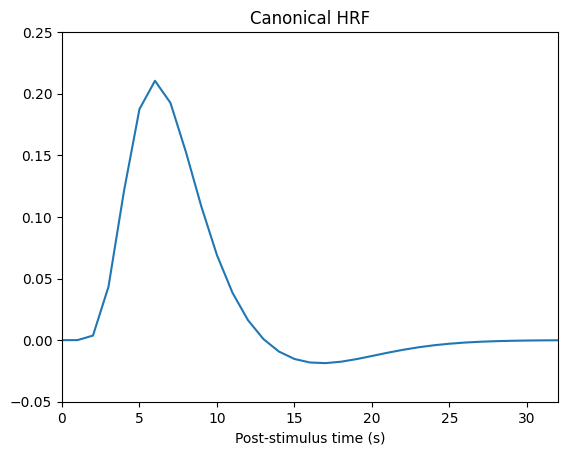

In [89]:
def canonical_hrf(dt):
    # Haemodynamic response function (HRF) = SPM's difference of 2 gamma functions
    p = [6, 16, 1, 1, 6, 0, 32]  # default parameters
    u = np.arange(0, np.ceil(p[6] / dt) + 1) - p[5] / dt
    hrf = sp.stats.gamma.pdf(u, p[0] / p[2], p[2] / dt) - sp.stats.gamma.pdf(u, p[1] / p[3], p[3] / dt) / p[4]
    hrf = hrf / np.sum(hrf)
    return hrf

hrf = canonical_hrf(1)
plt.figure(); plt.plot(np.arange(33), hrf);
plt.axis([0, 32, -0.05, 0.25]); plt.xlabel('Post-stimulus time (s)'); plt.title('Canonical HRF');


We can now simulate fMRI data by convolving it with delta functions that represent brief neural activity assumed to occur whenever we present a stimulus:

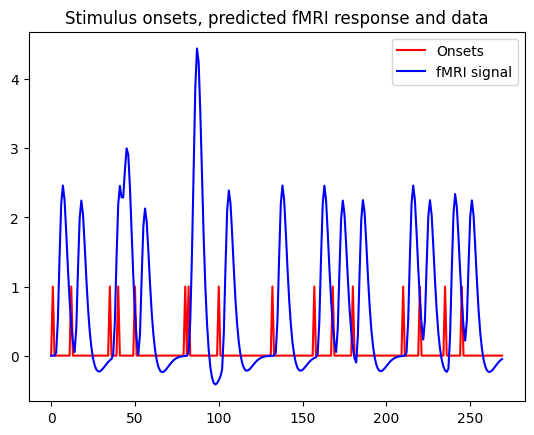

In [90]:
N = 270  # A run of 270 fMRI scans
# Create some onsets, roughly jittered across run:
r = [1, 12, 35, 40, 50, 80, 82, 100, 132, 157, 168, 180, 210, 220, 235, 245]
ons = np.zeros(N)
ons[r] = 1

plt.figure(); plt.plot(ons, color='r'); plt.title('Stimulus onsets, predicted fMRI response and data');
ys = np.convolve(ons, hrf)[:N] # Convolve with HRF
ys = ys / np.std(ys)  # scale so visible on same axis
plt.plot(ys, color='b'); plt.legend(['Onsets', 'fMRI signal']);

Some of the autocorrelation comes from the noise though - for example, ongoing neural activity unrelated to our stimuli, which would also be expressed via the HRF, plus aliased biorhythms (such as cardiac), plus slow "scanner drift":

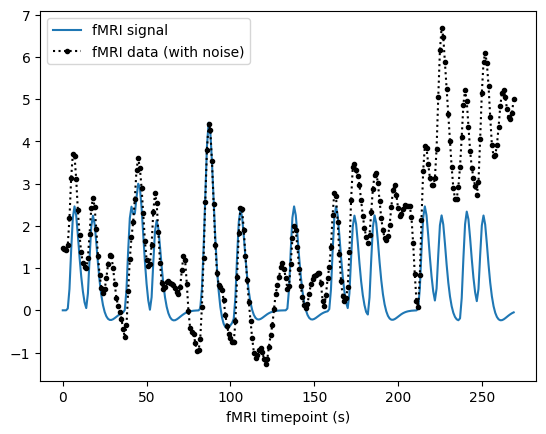

In [91]:
plt.figure(); plt.plot(ys);
np.random.seed(1) # ensure some reasonable (reproducible) noise
n = np.convolve(np.random.randn(N)*2, hrf)[:N] # non-stimulus-locked neural noise, expressed through same HRF
y = ys + n
d = np.arange(1, N+1)[:,np.newaxis] # create some slow drift too
d = np.sum(polynom(d,2),axis=1)
y = y + d
plt.plot(y, ':k.'); plt.axis('tight'), plt.xlabel('fMRI timepoint (s)');
plt.legend(['fMRI signal', 'fMRI data (with noise)']);

### Temporal Basis Sets, Filtering and Autocorrelated error

If we do not know the shape of the HRF, we can use a "temporal basis set". Several options are discussed in the literature, but here will use an "FIR" basis set of tophat functions every 2s of the 32s after each onset. This produces the design matrx below, which we can estimate with a GLM:

F-test for FIR (assuming error white): F(16,253)=6.396, p=0.000


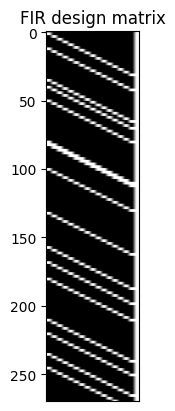

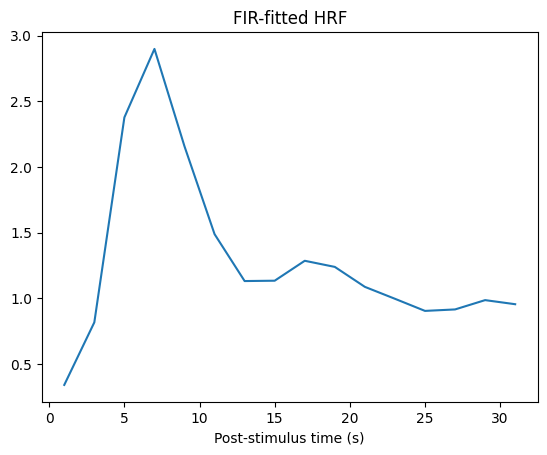

In [92]:
num_bins = int(16) # Number of bins 
bin_dur  = int(2)  # Bin duration (s)
FIR = np.kron(np.eye(num_bins),np.ones((bin_dur,1)))
X = np.zeros((N,num_bins))
for b in range(num_bins):
    X[:,b] = np.convolve(ons,FIR[:,b])[:N]
X = np.append(X, np.ones((N,1)), axis=1)
plt.figure(); plt.imshow(X, cmap='gray', aspect=0.25);
plt.title('FIR design matrix'); plt.xticks([]);

B, sigma, R2, r = glm_fit(y, X)
plt.figure(); plt.plot(np.round(np.arange(0.5,num_bins,1)*bin_dur), B[:-1] + B[num_bins])
plt.xlabel('Post-stimulus time (s)'); plt.title('FIR-fitted HRF');
T,F,df,p = glm_con(np.eye(num_bins), X, B, sigma, r)
print(f'F-test for FIR (assuming error white): F({int(df[0])},{int(df[1])})={F:.3f}, p={p:.3f}')

The FIR parameters roughly resemble the true HRF used to create the data, and the F-test suggests that there is a (highly) significant stimulus-locked response. Note this is effectively a "deconvolution", and there are other temporal basis sets possible (which could also be applied to overlapping ERPs to stimuli that are jittered over intervals <~1s). 

However, this F-test assumes the error is IID, ie spherical, which we can see is unlikely from the residuals: they show temporal smoothness and slow drift, given the way the noise was created above:

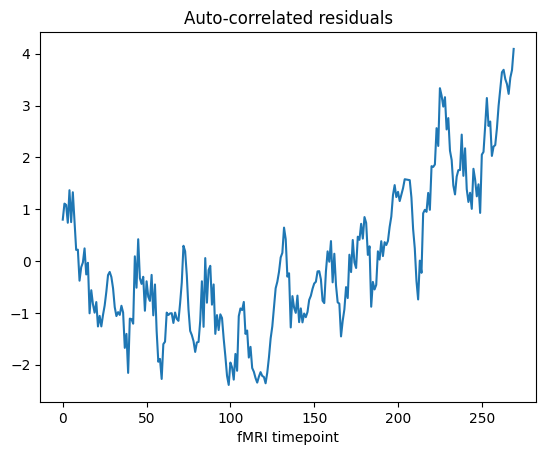

In [93]:
plt.figure(); plt.plot(r); plt.xlabel('fMRI timepoint'); plt.title('Auto-correlated residuals');

Some of the typical autocorrelation in fMRI noise (that induced by the slow drift above) can be removed by high-pass filtering, which can be achieved by adding a set of sinusoids to the design matrix (so-called "Discrete Cosine Transform", DCT):

F-test for FIR (assuming error white): F(16,249)=26.273, p=0.000


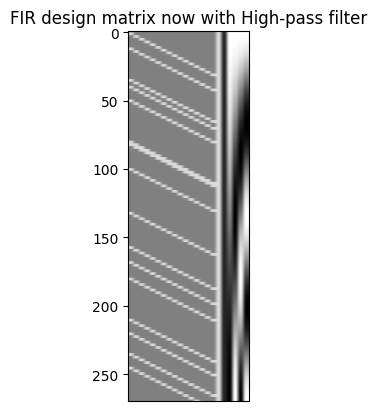

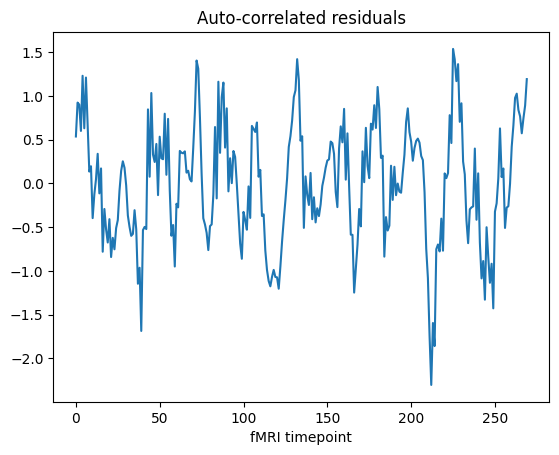

In [94]:
HPC = int(np.fix(2*N/128 + 1)) # DCT cutoff if highpass filtering to 1/128s
DCT = np.full((N, HPC), np.nan)
t = np.arange(N)
for k in range(HPC):
    DCT[:, k] = np.sqrt(2/N) * np.cos(np.pi * (2*t + 1) * k / (2*N))
X = np.concatenate((X, (DCT - DCT.mean(axis=0)) / DCT.std(axis=0)), axis=1)
plt.figure(); plt.imshow(X, cmap='gray', aspect=0.25);
plt.title('FIR design matrix now with High-pass filter'); plt.xticks([]);
B, sigma, R2, r = glm_fit(y, X)

c = np.eye(num_bins)
T,F,df,p = glm_con(c, X, B, sigma, r)
print(f'F-test for FIR (assuming error white): F({int(df[0])},{int(df[1])})={F:.3f}, p={p:.3f}')
plt.figure(); plt.plot(r); plt.xlabel('fMRI timepoint'); plt.title('Auto-correlated residuals');

While the residuals no longer show slow drift (and the F-statistic has increased), they are still autocorrelated. One way to model this specific type of nonsphericity is an "AR(p)" model (p-th order autoregressive model). If we assume an "AR(1) + white noise" model, for example, this predicts that the (population) error covariance can be modelled as a combination of two "covariance components" (Q below): the first predicted by the AR(1) component and the second repesenting additional independent (white) noise at each timepoint:

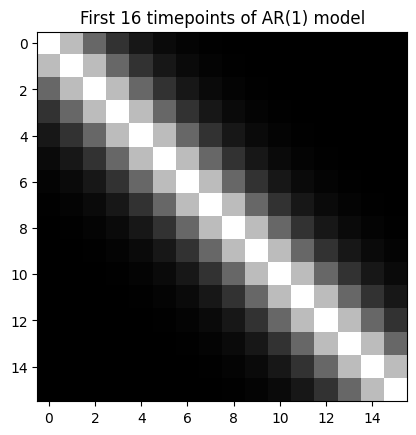

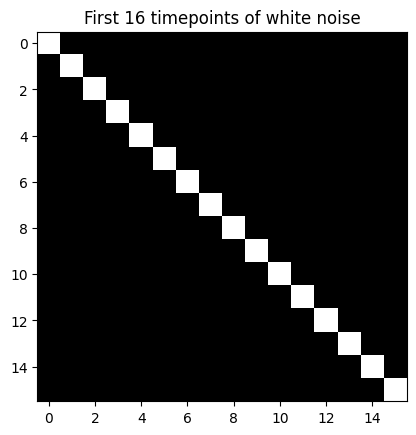

In [95]:
Q = [None] * 2
t = np.arange(1, N+1)
Q[0] = sp.linalg.toeplitz(t * np.exp(-t))
Q[1] = np.eye(N)
plt.figure(); plt.imshow(Q[0][:16,:16], cmap='gray'); plt.title('First 16 timepoints of AR(1) model');
plt.figure(); plt.imshow(Q[1][:16,:16], cmap='gray'); plt.title('First 16 timepoints of white noise');

If we assume that the error comes from such an AR(1)+WN error process, then we can use an estimate of this to "pre-whiten" the data. This prewhitening matrix "W" is estimated by the "estimate_autocorrelation" function:

In [96]:
from scipy.linalg import pinv, sqrtm

def estimate_autocorrelation(r):
    # Fit an AR(1)+white noise model to covariance of residuals (V)
    # and return a pre-whitening matrix W. r is samp_size x num_tests
    # of residuals from fitting glm
    
    N = r.shape[0]
    t = np.arange(1, N+1)
    Q = [sp.linalg.toeplitz(t * np.exp(-t)),  # AR(1)
        np.eye(N)]                    # White Noise
    QX = np.stack((Q[0].flatten(), Q[1].flatten()), axis=1)
    if r.ndim == 1:
        r=r[:,np.newaxis]
    V = r @ r.T
    V = V.flatten()
    h = np.linalg.pinv(QX) @ V
    V = Q[0]*h[0] + Q[1]*h[1]
    W = rsqrtm(pinv(V)) 
    return V, W

def rsqrtm(V):
    # Matrix square root ensuring real numbers
    u, s, _ = np.linalg.svd(V, full_matrices=False)
    s = np.sqrt(np.abs(s))
    W = np.dot(u, np.dot(np.diag(s), u.T))
    W[np.abs(W) < 1e-6] = 0
    return W

We can fit the GLM once to estimate the residuals, estimate the autocorrelation (error) matrix from these, and then multiply both the data and model by the (squareroot) of the inverse of this error covariance:

In [97]:
B,sigma,R2,r = glm_fit(y, X)       # Fit GLM once to estimate residuals
V,W = estimate_autocorrelation(r)  # Estimate autocorrelation from residuals
T,F,df,p,B,R2,r = glm(W@y, W@X, c) # Refit GLM on whitened data and model
print(f'F-test for FIR (pre-whitening with AR(1)+WM), F({df[0]:.0f},{df[1]:.0f})={F.item():.2f}, p={p.item():.3f}')

F-test for FIR (pre-whitening with AR(1)+WM), F(16,249)=11.85, p=0.000


Notice how we have now recovered the original dfs.

However, estimating the true error covariance from the residuals can be inefficient (noisy), as shown below, and mis-estimation can result incorrect statistics after prewhitening. One way to improve its estimation is to pool data across samples, e.g, voxels. If we assume the error covariance is identical across voxels, we can estimate it much more precisely by repeating the above for many voxels, as shown below. 

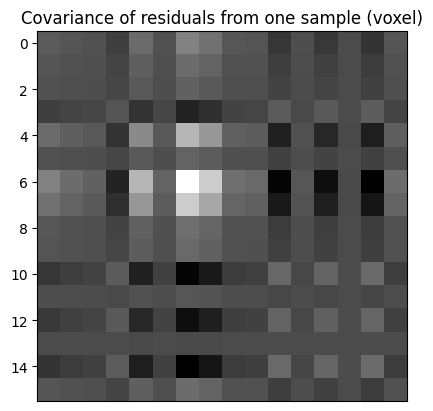

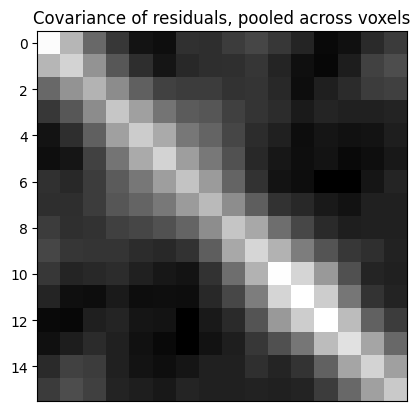

In [98]:
ce = np.outer(r,r); plt.figure(); plt.imshow(ce[:16,:16], cmap='gray', aspect=1);
plt.title('Covariance of residuals from one sample (voxel)'); plt.xticks([]);

num_tests = 100
y = np.random.multivariate_normal(np.zeros(N), Q[0], num_tests).T # y now matrix 
with np.errstate(invalid='ignore'): # This is numpy problem after installing pymer4 (see https://github.com/numpy/numpy/issues/24067)
    B, sigma, R2, r = glm_fit(y, X)
    ce = r@r.T; plt.figure(); plt.imshow(ce[:16,:16], cmap='gray', aspect=1); 
plt.title('Covariance of residuals, pooled across voxels'); plt.xticks([]);

Note that we are calling the "glm_fit" function with a time-by-voxel matrix rather than vector of data, which is useful for simultaneously fitting a large number of GLMs. If you run the code below (though it will take a while), you can see that such "voxel-wide" estimation of nonsphericity results in better control of FPR than trying to estimate on each voxel separately:

In [99]:
N = 90 # Take subset of timepoints to speed up
ys = np.convolve(ons, hrf)[:N]; ys = ys / np.std(ys) # Convolve with HRF
ys = np.repeat(ys[:,np.newaxis], num_tests, axis=1)
X = X[:N,:(num_bins+1)] # No drifts in data

num_samp = int(1e2)  # to speed-up - better as 1e3+
num_tests = int(1e1) # to speed-up - better as int(1e2)
p = np.empty((num_samp,num_tests))
pp = np.empty((num_samp,num_tests))
for s in range(num_samp):
    #y = ys + np.random.multivariate_normal(np.zeros(N), Q[0][:N,:N]*5, num_tests).T # if want some signal
    y = np.random.multivariate_normal(np.zeros(N), Q[0][:N,:N], num_tests).T # If want FPR
    for t in range(num_tests):
        B,sigma,R2,r = glm_fit(y[:,t], X)       # Fit GLM one voxel
        V,W = estimate_autocorrelation(r) 
        T,F,df,pval,B,R2,r = glm(W@y[:,t], W@X, c) 
        p[s,t] = pval
    with np.errstate(invalid='ignore'):    # This is a numpy problem after installing pymer4 (see https://github.com/numpy/numpy/issues/24067)
        B,sigma,R2,r = glm_fit(y, X)       # Fit GLM to all voxel simultaneously
        V,W = estimate_autocorrelation(r)  
        T,F,df,pval,B,R2,r = glm(W@y, W@X, c) 
    pp[s,:] = pval

fpr = np.sum(p < alpha, axis=0) / num_samp
print(f'Voxel-wise nonsphericity correction, mean FPR={np.mean(fpr):.3f}')
#print(f'Voxel-wise nonsphericity correction, std FPR={np.std(fpr):.3f}')
fpr = np.sum(pp < alpha, axis=0) / num_samp
print(f'Voxel-wide nonsphericity correction, mean FPR={np.mean(fpr):.3f}')
#print(f'Voxel-wide nonsphericity correction, std FPR={np.std(fpr):.3f}')

Voxel-wise nonsphericity correction, mean FPR=0.234
Voxel-wide nonsphericity correction, mean FPR=0.079


However, even when pooling across voxels in the voxel-wide analysis, we are not controlling the FPR properly. This is because the residuals do not capture just the true error, but also effects of removing the signal (what can be explained by the design matrix). The proper way is to estimate the GLM parameters (B) and the error model (hyper)parameters (h) simultaneously, using an iterative algorithm like "Restricted Maximum Likelihood" (ReML). This is available in many software packages (including that used for the mixed effects models below), but is beyond the present remit.

Finally, note that even without a task, the GLM can be used to estimate functional connectivity between two voxels/ROIs, by putting the timeseries of one ROI into X, together with confounds like above, when fitting the timeseries from the other ROI. The resulting p-value will be properly adjusted for filtering, autocorrelation etc, unlike when simply estimating the Pearson correlation coefficient between two ROIs after preprocessing their data independently.

## Heirarchical Linear Models
So far, we have modelled just one source of error variance (one "random effect"), e.g, across participants in the T-tests and ANOVAs, or across timepoints in the timeseries analyses. We often have mulitple measurements (within each condition) for each of mulitple participants. For example, we might collect reaction times from 100 trials in each of 10 participants. In this case, our power depends on both the variance across trials within participants, and the variance in the mean across participants. This can be modelled properly in "mixed effects" models below, but first we start with a common approximation, which is to average across trials within each participant, and simply perform a test on these means across participants (i..e, ignoring the error associated with each trial-average). 

This is sometimes called the "summary statistic" or two-stage approach. It is illustrated below, along with effects of the number of trials relative to number of participants:

In [100]:
num_ppt = [10, 20, 10]   # Number of participants
num_trl = [100, 10, 20]  # Number of trials per participant
pop_std = [1, 1, 1]      # Std of mean across participants
trl_std = [10, 10, 10]   # Std across trials
pop_mean = 1
num_samp = 1000
for e in range(len(num_ppt)):
    pop_ppt = pop_mean + pop_std[e] * pop
    ppt_mean = sample_pop(pop_ppt, num_ppt[e], num_samp)
    y = np.full((num_ppt[e], num_samp), np.nan)
    for p in range(num_ppt[e]):
        for s in range(num_samp):
            pop_trl = ppt_mean[p, s] + trl_std[e] * pop
            ppt_vals = sample_pop(pop_trl, num_trl[e], 1)
            y[p, s] = np.mean(ppt_vals)
    pval = T2p_higher(one_t(y), num_ppt[e] - 1)
    pr = np.sum(pval < alpha) / num_samp
    print(f'Positive rate with {num_ppt[e]} participants with {num_trl[e]} trials = {pr:.2f}')

Positive rate with 10 participants with 100 trials = 0.67
Positive rate with 20 participants with 10 trials = 0.39
Positive rate with 10 participants with 20 trials = 0.33


In this situation where variability across trials is much higher than variability across participants, having 10x more trials produces higher power than having 2x more participants (cf. the first two results above); though if the total number of trials (ie, num_ppt*num_trls) is fixed, it is generally better to have more participants (cf. the last two results above).

**Exercise: Try situation where variability across trials is less than than variability across participants?**

But what happens if different participants have different numbers of trials? Let's build up some data first:

In [101]:
num_ppt = 20
pop_std = 1
trl_std = 10
alpha = 0.05
num_trl = [10*p for p in range(1, num_ppt+1)] # participants ordered by number of trials!
pop_ppt  = pop*pop_std + pop_mean
ppt_mean = sample_pop(pop_ppt, num_ppt, num_samp)

samp_means = np.full((num_ppt, num_samp), np.nan)
samp_vals = np.full((sum(num_trl), num_samp), np.nan)

for s in range(num_samp):
    vals = np.array([])
    for p in range(num_ppt):
        pop_trl  = ppt_mean[p,s] + trl_std*pop
        ppt_vals = sample_pop(pop_trl, num_trl[p], 1)
        samp_means[p, s] = np.mean(ppt_vals)
        vals = np.vstack((vals, ppt_vals)) if vals.size else ppt_vals
    samp_vals[:, s] = np.squeeze(vals) # Used in LME below

In this case, the mean for a participant who did more trials is a more accurate estimate, so we could increase the contribution of this participant's mean to the estimate of the population mean. This is called "weighting" (a simple case of "weighted least squares"), which can produce more sensitive tests, as illustrated below:

In [102]:
# Unweighted test on means
pval = T2p_higher(one_t(samp_means),num_ppt-1)
pr = np.sum(pval < alpha) / num_samp
print(f'Power for standard T-test = {pr:.2f}')

# Weighted least squares
w = np.repeat(np.array([num_trl]), num_samp, axis=0).T
wm = np.sum(np.multiply(samp_means,w),axis=0) / np.sum(w,axis=0)
wv = (np.sum(np.multiply(samp_means**2,w),axis=0) / np.mean(w,axis=0) - num_ppt * wm**2) / (num_ppt - 1)
wT = wm / (np.sqrt(wv) / np.sqrt(num_ppt))
pval = T2p_higher(wT, num_ppt-1)
pr = np.sum(pval < alpha) / num_samp
print(f'Power for weighted T-test = {pr:.2f}')

Power for standard T-test = 0.82
Power for weighted T-test = 0.91


Note how giving more weight to participants whose mean has been estimated from more trials results in a more powerful final test. Such highly "unbalanced" designs are where the summary statistic approach (that ignores estimation errror associated with each participant) becomes non-optimal. However, this weighting is just a simple case of more general "mixed effects" models, to which we next turn, in which one can have more than one random effect, i.e., variance due to participants, variance due to trials, etc...

More generally, this situation can be represented as a heirarchical set of GLMs:

    y    = X1 * B1 + e1

    B1  = X2 * B2 + e2

So in example above, B1 captures the mean across trials for each participant, while B2 is the mean across participants. In a Bayesian context, B2 can also function as an "empirical prior" that can "regularise" the estimates of individual participant means (B1). Note that there can be more than 2 levels (e.g, trials, sessions, participants), and also that the second level does not have to refer to participants; the second-level could refer to the mean across voxels for example ("spatial regularisation").

### Linear Mixed Effects (LME) Models
We finish with LME models, which can no longer be solved by simply matrix inversion (OLS/WLS), and require iterative techniques like ReML mentioned above. Because these are quite complex in general, we switch to calling the "lmer" function from the "R" freeware package (via the python "pymer4" API). (There is a Python package for LME models called "statsmodels", but it does not use notation conventional for our field.) First though, we need to represent the data more generally, in which each observation is a row, and each column indicates where that observation comes from, e.g, a particular participant ID, condition and possiby a particular stimulus ID (sometimes called "long-format"). In the python package "pandas", these are called "data frames". 

Let's start by creating a long-format table for the data created above, with just one condition and variable numbers of trials across participants:

In [103]:
import pandas as pd

tab = pd.DataFrame(samp_vals[:,0], columns=["y"])
part_ID = list()
for p in range(num_ppt):
    for t in range(num_trl[p]):
        part_ID.append(p+1)
tab.insert(1, "Participant", part_ID)

We can now fit an LME model. The generic "Wilkinson" notation for such a model is "y ~ 1 + F1 + (1 + F1|R1)", where the "1" represents an intercept, F1 is a fixed effect and R1 is a random effect (e.g., participants). We will demonstrate more than one fixed and random effect later. The term "(1|R1)" is known as the "random intercept" (e.g, capturing the mean of each participant; akin to the participant columns in the GLM section earlier), and the term "(F1|R1)" is a "random slope" (e.g, allowing for the possibility that different participants show different effect sizes of F1).

_Interesting factoid: I couldn't find any interesting factoid about Graham Wilkinson, except that he liked to design new ways of representing railway timetables._

However, for the one-sample T-test example above, there is just an intercept (no other fixed effect) and there is only a random intercept, so the model is simply "y ~ 1 + (1|participant)":

In [104]:
from pymer4.models import Lmer
import warnings # pymer4 needs to be updated to python3.1, so suppress warning to do with dataframe
warnings.filterwarnings("ignore", category=FutureWarning, message=".*DataFrame.applymap.*")

model = Lmer("y ~ 1 + (1|Participant)", data=tab)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: y~1+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 2100	 Groups: {'Participant': 20.0}

Log-likelihood: -7793.641 	 AIC: 15593.283

Random effects:

                    Name     Var    Std
Participant  (Intercept)   2.136  1.461
Residual                  96.985  9.848

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci    SE      DF  T-stat  P-val Sig
(Intercept)     0.498  -0.304    1.301  0.41  17.487   1.217   0.24    


We can then compare the power of LME with WLS and summary statistic approaches above (though it will take several minutes to run):

In [105]:
from IPython.utils.io import capture_output # to suppress output from each LME fit below

num_samp = int(1e3) # Should be 1e3 to compare to above
with capture_output():
    pval = np.full((num_samp,1), np.nan)
    for s in range(num_samp):
        tab = pd.DataFrame(samp_vals[:,s], columns=["y"])
        tab.insert(1, "Participant", part_ID)
        model = Lmer("y ~ 1 + (1|Participant)", data=tab)
        model.fit()
        #pval[s] = model.coefs["P-val"].item() # This actually uses Satterthwaite correction to dfs which don't want right now
        tval = model.coefs["T-stat"].item()
        pval[s] = T2p_2tails(tval, len(tab)-num_ppt-1)
pr = np.sum(pval < alpha) / num_samp
print(f'Power for LME = {pr:.2f}')

Power for LME = 0.86


which is higher than for the weighted and unweighted two-stage T-tests in the preceding section. This is largely because of the massive increase in dfs (at price of needing a more complex model of random effects). 

### Simpsons paradox
This paradox relates to a pattern of data in which an independent variable shows a relationship with the dependent variable across trials within each participant, but a relationship of the opposite sign for the means across trials. This is plotted below, where each participant's data is a different colour, while the black line shows the linear fit to the means across participants (using the GLM to estimate those linear slopes).

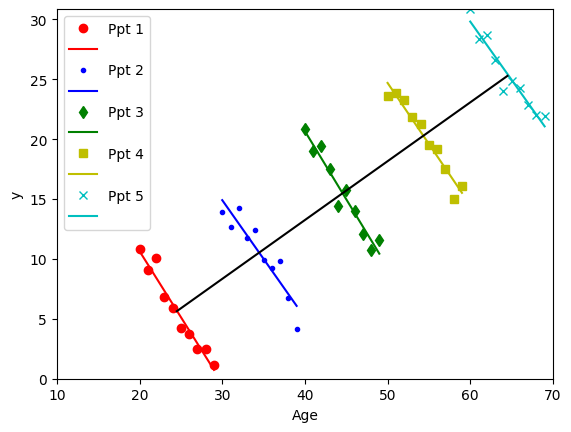

In [106]:
num_trl = 10
num_ppt = 5
ppt_ID = []
age = np.empty([num_trl, num_ppt])
y = np.empty([num_trl, num_ppt])
ppt_age = np.arange(20, 10*(num_ppt+1)+1, 10)

fig, ax = plt.subplots()
mker = ['ro', 'b.', 'gd', 'ys', 'cx']
txt = []
for p in range(num_ppt):
    for t in range(num_trl):
        age[t,p] = ppt_age[p] + t
        y[t,p]  = ppt_age[p]*0.5 - t + np.random.randn()
    ppt_ID.extend([p+1] * num_trl)
    ax.plot(age[:,p], y[:,p], mker[p])
    X = np.stack((age[:,p], np.ones(num_trl)), axis=1)
    _,_,_,_,B,_,_ = glm(y[:,p], X, np.array([1, 0])) 
    X = np.array([age[0,p], age[num_trl-1,p]])
    ax.plot(X, B[0]*X + B[1], color=mker[p][0])
    txt.append(f'Ppt {p+1}'); txt.append('')

X = np.stack((np.mean(age,axis=0).T, np.ones(num_ppt)), axis=1)
_,_,_,_,B,_,_ = glm(np.mean(y,axis=0).T, X, np.array([1, 0])) 
X = np.array([np.mean(age[:,0]), np.mean(age[:,num_ppt-1])])
ax.plot(X, B[0]*X + B[1], color='k');
ax.set_xlim(10, 10*(num_ppt+2)); ax.set_ylim(0, np.max(y));
ax.set_xlabel('Age'); ax.set_ylabel('y');
ax.legend(txt, loc='upper left');

tab = np.stack((y.T.flatten(), age.T.flatten(), ppt_ID)).T
tab = pd.DataFrame(tab, columns=['y', 'Age', 'Participant'])

Notice how there is a positive effect of age on the mean values across participants, but a negative effect of age within each participant. If we fit an LME:

In [107]:
model = Lmer("y ~ Age + (1|Participant)", data=tab)
print(model.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: y~Age+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'Participant': 5.0}

Log-likelihood: -88.031 	 AIC: 184.062

Random effects:

                    Name      Var     Std
Participant  (Intercept)  583.996  24.166
Residual                    0.897   0.947

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci      SE      DF  T-stat  P-val  Sig
(Intercept)    61.584  40.015   83.153  11.005   4.266   5.596  0.004   **
Age            -1.036  -1.128   -0.945   0.047  44.301 -22.268  0.000  ***


we see a negative effect of Age, as expected (with the different means across participants accommodated by the random intercepts). One explanation for this pattern could be a variable like "environmental pollution", which might increase over the years and impair cognitive development during childhood, but because older people were born earlier (when there was less pollution), there is a positive effect of age on their average scores.

### Model Comparison
The real advantage of LME models comes with more complex heirarchical designs with multiple random effects. So let's generate some data from two fixed effects (a 2x2 design), in which there is a main effect of the second factor (f2), and in which each randomly-sampled participant is tested on a set of randomly-sampled stimuli (i.e., two random effects):

In [108]:
np.random.seed(1)
pop_mean = 1
pop_std = 2
num_ppts = 20  # Number of participants
ppt_vals = np.random.randn(num_ppts) * pop_std + pop_mean

stm_mean = 1
stm_std = 4
num_stms = 10  # Number of stimuli
stm_vals = np.random.randn(num_stms) * stm_std + stm_mean
# stm_vals[5:10] += 4  # Uncomment if want f2 to be confounded by stimuli

cond_vals = np.array([[-1, 1], [-1, 1]])  # fixed effects in 2x2 design (main effect of f2)

trl_std = 1  # Noise on each trial

ppt_ids = []; f1_ids = []; f2_ids = []; stm_ids = []; y = []
for f1 in range(2):
    for f2 in range(2):
        for p in range(num_ppts):
            for s in range(num_stms):
                yt = np.random.randn() * trl_std + cond_vals[f1, f2] + ppt_vals[p] + cond_vals[f1, f2] * ppt_vals[p] + stm_vals[s]
                # yt = np.random.randn() * trl_std + cond_vals[f1, f2] + ppt_vals[p] + cond_vals[f1, f2] * ppt_vals[p] + stm_vals[(f2) * num_stms // 2 + s // 2]  # Uncomment if stimulus ID differs by f2                
                y.append(yt)
                f1_ids.append(f1 + 1)  # factor 1 level
                f2_ids.append(f2 + 1)  # factor 2 level
                ppt_ids.append(p + 1)  # participant ID
                stm_ids.append(s + 1)  # stimulus ID
                # stm_ids.append((f2) * num_stms // 2 + (s // 2) + 1)  # Uncomment if stimulus ID differs by f2

# Create a DataFrame similar to MATLAB's table
tab = pd.DataFrame({'y': y, 'F1': f1_ids, 'F2': f2_ids, 'Participant': ppt_ids, 'Stimulus': stm_ids})

# Display the first 6 rows
print(tab.head(6))

          y  F1  F2  Participant  Stimulus
0 -5.094137   1   1            1         1
1  4.182141   1   1            1         2
2  2.919190   1   1            1         3
3  1.164772   1   1            1         4
4  2.932178   1   1            1         5
5 -2.747576   1   1            1         6


Note that we have also added a random slope for f2 with the term _"cond_vals(f1,f2)*ppt_vals(p)" above_. We can now fit a series of models, and use model comparison to determine the best one. We start with assuming only random intercepts below. Note that the "\*" is a symbol used to indicate a factorial design, such that "f1\*f2" expands to "f1 + f2 + f1:f2", where "f1:f2" is the interaction term (i.e, the two factors expand to three fixed effects):

In [109]:
m1 = Lmer("y ~ F1*F2 + (1|Participant) + (1|Stimulus)", data=tab)
print(m1.fit())
l1 = m1.logLike
print(f'\nRandom intercepts only: LogLikelihood = {l1:.0f}, AIC = {m1.AIC:.0f}')

Linear mixed model fit by REML [’lmerMod’]
Formula: y~F1*F2+(1|Participant)+(1|Stimulus)

Family: gaussian	 Inference: parametric

Number of observations: 800	 Groups: {'Participant': 20.0, 'Stimulus': 10.0}

Log-likelihood: -1910.717 	 AIC: 3835.433

Random effects:

                    Name     Var    Std
Participant  (Intercept)   4.912  2.216
Stimulus     (Intercept)  10.817  3.289
Residual                   6.026  2.455

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)    -2.819  -5.646    0.008  1.442   31.851  -1.954  0.059    .
F1             -0.045  -1.121    1.030  0.549  768.000  -0.083  0.934     
F2              3.320   2.244    4.396  0.549  768.000   6.049  0.000  ***
F1:F2           0.011  -0.670    0.691  0.347  768.000   0.031  0.976     

Random intercepts only: LogLikelihood = -1911, AIC = 3835


This recovers the significant main effect of F2, but is potentially invalid because we are not allowing for the possiblity that each fixed effect could depend on participant, i.e, we are not modelling random slopes (i.e, ignoring structure in the error). So alternatively, we could fit the most complex model and compare to the model above, using a Likelihood Ratio Test (for nested models) or AIC (for any models):

In [110]:
m2 = Lmer("y ~ F1*F2 + (F1*F2|Participant) + (F1*F2|Stimulus)", data=tab)
print(m2.fit())
l2 = m2.logLike
print(f'\nMost complex model: LogLikelihood = {l2:.0f}, AIC = {m2.AIC:.0f}')

# Code for likelihood ratio test
from scipy.stats import chi2 
C2 = -2*(l1-l2)
df_m1 = (m1.AIC+2*l1)/2 # Hacky way of getting dfs!
df_m2 = (m2.AIC+2*l2)/2 # Hacky way of getting dfs!
df_diff = df_m2 - df_m1
#df_diff = (20+10)*3 # 20 participant slopes and 10 stimulus slopes for 3 new effects
p = 1 - chi2(df_diff).cdf(C2)
print(f'\nDifference in LogLikelihoods = {(l1-l2):.0f}, df = {df_diff:.0f}, p = {p:.3f}')

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: y~F1*F2+(F1*F2|Participant)+(F1*F2|Stimulus)

Family: gaussian	 Inference: parametric

Number of observations: 800	 Groups: {'Participant': 20.0, 'Stimulus': 10.0}

Log-likelihood: -1222.177 	 AIC: 2494.353

Random effects:

                    Name     Var    Std
Participant  (Intercept)  24.487  4.948
Participant           F1   0.226  0.475
Participant           F2  22.708  4.765
Participant        F1:F2   0.082  0.286
Stimulus     (Intercept)  13.973  3.738
Stimulus              F1   0.204  0.451
Stimulus              F2   0.245  0.495
Stimulus           F1:F2   0.059  0.244
Residual                   0.966  0.983

                     IV1    IV2   Corr
Participant  (Intercept)     F1 -0.631
Participant  (Intercept)     F2 -1.000
Participant  (Intercept)  F1:F2  0.628
Participant           F1     F2  0.621
Participant           F1  F1:F2 -1.000
Participant           F2  F1:F2 -0.618

Model comparison shows that m2 is a better model (according to LRT, and AIC, where lower AIC is better). The p-value for the main effect of F2 has also increased slightly (less significant) because we are now correctly modelling structure in the error. However, we know this model is also overly complex (since we generated data with only one random slope), so we can also fit the "true" model: 

In [111]:
m3 = Lmer("y ~ F2 + (F2|Participant) + (1|Stimulus)", data=tab)
print(m3.fit())
l3 = m3.logLike
print(f'\nMost complex model: LogLikelihood = {l3:.0f}, AIC = {m3.AIC:.0f}')

C2 = -2*(l3-l2)
df_m3 = (m3.AIC+2*l3)/2 # Hacky way of getting dfs!
df_diff = df_m2 - df_m3
#df_diff = (20+10)*3 # 20 participant slopes and 10 stimulus slopes for 3 new effects
p = 1 - chi2(df_diff).cdf(C2)
print(f'\nDifference in LogLikelihoods = {(l3-l2):.0f}, df = {df_diff:.0f}, p = {p:.3f}')

Linear mixed model fit by REML [’lmerMod’]
Formula: y~F2+(F2|Participant)+(1|Stimulus)

Family: gaussian	 Inference: parametric

Number of observations: 800	 Groups: {'Participant': 20.0, 'Stimulus': 10.0}

Log-likelihood: -1224.120 	 AIC: 2462.240

Random effects:

                    Name     Var    Std
Participant  (Intercept)  20.500  4.528
Participant           F2  20.352  4.511
Stimulus     (Intercept)  10.880  3.299
Residual                   0.989  0.994

                     IV1 IV2  Corr
Participant  (Intercept)  F2  -1.0

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val Sig
(Intercept)    -2.887  -5.745   -0.030  1.458  23.969  -1.980  0.059   .
F2              3.336   1.354    5.318  1.011  19.002   3.299  0.004  **

Most complex model: LogLikelihood = -1224, AIC = 2462

Difference in LogLikelihoods = -2, df = 18, p = 1.000


This time, we cannot reject either model according to the likelihood ratio test, but note that the true (simpler) model m3 has even lower AIC (this metric penalises the likelihood by the number of parameters in the model), so we could proceed with inferences based on the simpler model. Note also that the p-value for the main (fixed) effect of F2 is slightly lower in the simpler model, because the residual dfs are larger.

If you don't know anything about the structure of the error, one approach is to start with the most complex model, and gradually reduce its complexity with a series of model comparisons until the simpler model is no longer sufficient. Note that sometimes (complex) models will not converge, in which case it is often necessary to assume simpler models. 

Note that the computational expense of LMEs (and occasional convergence problems) can be an issue when applying over many samples, eg 1e6 voxels in MRI images, but there are simplified approximations, like the "sandwich estimator".

This concludes this brief introduction to statistics for hypothesis testing. Any corrections/comments/additions welcomed!